# #**Learning To Smell**

# Predicting the relationship between a moleculeâ€™s structure and its odor remains
# a difficult, decades-old task. This problem, termed quantitative structure-odor
# relationship (QSOR) modeling, is an important challenge in chemistry, impacting
# human nutrition, manufacture of synthetic fragrance, the environment, and sensory
# neuroscience.
#
# The main challange lies in getting good representation of the structure of molecules that can be used by our machine learning models to get accurate predictions of odor descriptors.There are multiple approaches to solving the problem, through the course of this notebook we'll explore and compare each approach.

# # **Introduction**

# Smell begins at the back of nose, where millions of sensory neurons lie in a strip of tissue called the olfactory epithelium. The tips of these cells contain proteins called receptors that bind odor molecules.
#
# The complexity of receptors and their interactions with odor molecules are what allow us to detect a wide variety of smells. And what we think of as a single smell is actually a combination of many odor molecules acting on a variety of receptors, creating an intricate neural code that we can identify as the scent of a rose or freshly-cut grass.

In [ ]:
from IPython.core.display import Image
#Image("handson-ml/datasets/Summer_Project_Learning_To_Smell!/Images/rsz_screenshot_from_2019-10-24_21-54-12.png",height=500,width=750)
# The basic idea is that given the encoded structure of our molecule we have to predict its odor through machine learning techniques.
#
# The biological equivalent would be triggering of olfactory receptors in our nose that send signals to our brain distinguishing the unique odour.
#

In [ ]:
pip install scikit-learn


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install requests


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 2.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# !pip install scikit-multilearn==0.2.0
%pip install scikit-multilearn
# !pip install networkx==2.6.2

  Using cached scikit_multilearn-0.2.0-py3-none-any.whl (89 kB)

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import os
import string
import sklearn
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import sys
import os
import requests
import subprocess
import shutil
sys.path.append("handson-ml/datasets/Summer_Project_Learning_To_Smell!/Packages/scikit-multilearn-master/scikit-multilearn-master")
#sys.path.append("AppData\Roaming\Python\Python38\Scripts")
#sys.path.append("appdata\roaming\python\python38\site-packages")
#sys.path.append("anaconda3\lib\site-packages")
import skmultilearn

In [ ]:
!pip install numpy==1.19 --user
!pip install scipy==1.5.3 --user
!pip install rdkit-pypi==2021.09.4 --user
get_ipython().system('python --version')
!pip install pubchempy

     |████████████████████████████████| 15.3 MB 413 kB/s eta 0:00:011
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
     |████████████████████████████████| 29.0 MB 635 kB/s eta 0:00:01
     |████████████████████████████████| 16.8 MB 347 kB/s eta 0:00:01
Python 3.11.4
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13825 sha256=d595d505c3a786e3461bea6a7bdf266ed3963e3ccc771144c5ade8cc0204a1f6
  Stored in directory: /Users/niharikakhatri/Library/Caches/pip/wheels/b0/8c/ba/3b00b89931153bf5a4eaa8e73bd1b0319a879cc45175326854
Successfully built pubchempy


# ## About The Data

# The dataset has been taken from a recently conducted open challange by fermenich.It constitutes of a total of 4316 molecules in the training set and 1079 molecules in the test set.
#
# It contains the description of molecules (as its SMILES string), and the odors it possesses. The challenge is a multilabel classification problem, each molecule has multiple odors written in a form of a sentence with a single comma between each odor. Following are the columns in the dataset with their description:
#
# SMILES: Simplified molecular-input line-entry system (SMILES) is a specification in the form of a line notation for describing the structure of chemical species using short ASCII strings.This encoding into a string of characters is done to make the data machine readable. A unqiue molecular structure can be reproduced from each smile string.
#
# Odor (target): Its a combination of the odors of the molecules. Each odor is separated by a , to form an (odor) sentence

In [ ]:

#Image("handson-ml/datasets/Summer_Project_Learning_To_Smell!/Images/5059-cspotw-c8sc04175j-5-december-schematic_f2a-1600.jpg",height=400,width=500)


# | Bond type   |  Symbol|
# |----------|:-------------:|
# |Single bond |    -   |
# | Double bond |    =   |
# | Triple bond |    #   |
# | Aromatic bond |    *   |
# | Disconnected structures |    .   |


In [ ]:
#Image("handson-ml/datasets/Summer_Project_Learning_To_Smell!/Images/2.jpg",height=400,width=500)


# [This link provides a more detailed description of the syntax rules for the encoding](https://archive.epa.gov/med/med_archive_03/web/html/smiles.html)

# ## Importing The Data

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv("/Users/niharikakhatri/Desktop/Acads/UGP_Olfaction/data_ir.csv")

In [ ]:
train_ratio = 0.8  # 80% for training, 20% for testing

# Calculate the number of rows for each DataFrame
train_rows = int(len(data) * train_ratio)
test_rows = len(data) - train_rows

# Shuffle the DataFrame
df_shuffled = data.sample(frac=1, random_state=42)

# Split the DataFrame into train and test DataFrames
train_df = df_shuffled.iloc[:train_rows]
test_df = df_shuffled.iloc[train_rows:]

train_df.drop(columns=train_df.columns[0],inplace = True)
test_df.drop(columns=test_df.columns[0],inplace = True)

print("Training DataFrame (80%):")
print(train_df)

print("\nTesting DataFrame (20%):")
print(test_df)

train_df.to_csv("train_ir.csv")
test_df.to_csv("test_ir.csv")

Training DataFrame (80%):
                     SMILES                                               Odor
415    CCCCC=COC(=O)C(C)CCC                          Green, fruity, apple-like
1302                    NaN                                                NaN
2475  Oc1ccc2c(c1)oc(=O)cc2                              fruity,phenolic,spicy
1340   CCC(C)(C)SSC(C)(C)CC  Sufurous; allium, savory, meaty, green, vegeta...
1599    COC(OC)C(C)c1ccccc1  Green, mushroom, floral-citrus odor; fruity, f...
...                     ...                                                ...
1172                    NaN                                                NaN
814       CCCCCCCC(=O)OCCCC  Weak fruity, slightly green, oily, weak floral...
1852   CC(CCOC(=O)CC(=O)C)C                    sweet,green,herbal,fruity,burnt
2220         CC(=O)c1ccncc1                                         fruity,nut
2659  C=CCc1cc2c(cc1OC)OCO2                                             pepper

[2271 rows x 2 columns]



/var/folders/4l/bghpg15d1h13nd1gjhjrcx1h0000gn/T/ipykernel_6905/285315990.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=train_df.columns[0],inplace = True)
/var/folders/4l/bghpg15d1h13nd1gjhjrcx1h0000gn/T/ipykernel_6905/285315990.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=test_df.columns[0],inplace = True)


In [ ]:
data = pd.read_csv("train_ir.csv")
test_data = pd.read_csv("test_ir.csv")
data.head(10)

,Unnamed: 0,SMILES,Odor
0,415,CCCCC=COC(=O)C(C)CCC,"Green, fruity, apple-like"
1,1302,NaN,NaN
2,2475,Oc1ccc2c(c1)oc(=O)cc2,"fruity,phenolic,spicy"
3,1340,CCC(C)(C)SSC(C)(C)CC,"Sufurous; allium, savory, meaty, green, vegeta..."
4,1599,COC(OC)C(C)c1ccccc1,"Green, mushroom, floral-citrus odor; fruity, f..."
5,354,NaN,NaN
6,965,CCc1nc(C)oc1C,"Green, vegetative, nutty, hazelnut"
7,2067,c1ccc(cc1)CN=C=S,"herbal,musty,medicinal,spicy,oily"
8,527,CCCCC(C)O,"Mild fruity, fatty, fermented fusel notes, mus..."
9,2418,C=CCCCCCC=C,"fresh,citrus"


In [ ]:
# data=pd.read_csv("train.csv")
# train_supp=pd.read_csv("Data3.csv")
# test_data=pd.read_csv("test.csv")
# data.head(10)

,SMILES,SENTENCE
0,C/C=C/C(=O)C1CCC(C=C1C)(C)C,"fruity,rose"
1,COC(=O)OC,"fresh,ethereal,fruity"
2,Cc1cc2c([nH]1)cccc2,"resinous,animalic"
3,C1CCCCCCCC(=O)CCCCCCC1,"powdery,musk,animalic"
4,CC(CC(=O)OC1CC2C(C1(C)CC2)(C)C)C,"coniferous,camphor,fruity"
5,CCC[C@H](CCO)SC,tropicalfruit
6,CC(C)C(=O)OCc1ccco1,"fruity,coffee"
7,OC[C@H]1[C@H]2CC[C@H]3[C@@]1(C)CCCC([C@@H]23)(C)C,woody
8,CCc1ccc(cc1)CC(C=O)(C)C,"clean,fresh"
9,CC(C)[C@@H]1CC[C@@](C)([C@H]2CCC(=C[C@@H]12)C)O,"herbal,spicy,honey"


In [ ]:
train_supp

,SMILES,SENTENCE
0,CC(C)C1CCC(C)CC1OC(=O)CC(C)O,cooling
1,CC(=O)OCC(COC(=O)C)OC(=O)C,"clean,dairy,sour"
2,CCCCCCCC(=O)OC/C=C(/CCC=C(C)C)\C,"floral,fruity,fatty,musty,pungent"
3,CSc1cnccn1,"earthy,nut,sulfuric,ethereal"
4,CCC1N=C(C)C(C)S1,"meat,nut,musty,sulfuric,coffee,cacao,vegetable"
...,...,...
383,COC=O,"plum,ester"
384,CCC1=C(O)C(=O)C(O1)C,"bread,resinous,syrup"
385,CCc1ccc(C)o1,"fresh,chemical,burnt"
386,c1cc(sc1)SSc1cccs1,"plastic,mushroom"


In [ ]:
data=pd.concat([train_supp,data],axis=0).reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4704 entries, 0 to 4703
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   SMILES    4704 non-null   object
 1   SENTENCE  4704 non-null   object
dtypes: object(2)
memory usage: 73.6+ KB


In [ ]:
data["SENTENCE"]

0                                              cooling
1                                     clean,dairy,sour
2                    floral,fruity,fatty,musty,pungent
3                         earthy,nut,sulfuric,ethereal
4       meat,nut,musty,sulfuric,coffee,cacao,vegetable
                             ...                      
4699                                     floral,citrus
4700                                     watery,earthy
4701                                    sweet,ethereal
4702                                               nut
4703                                      woody,floral
Name: SENTENCE, Length: 4704, dtype: object

In [ ]:
data["Odor"]

0                               Green, fruity, apple-like
1                                                     NaN
2                                   fruity,phenolic,spicy
3       Sufurous; allium, savory, meaty, green, vegeta...
4       Green, mushroom, floral-citrus odor; fruity, f...
                              ...                        
2266                                                  NaN
2267    Weak fruity, slightly green, oily, weak floral...
2268                      sweet,green,herbal,fruity,burnt
2269                                           fruity,nut
2270                                               pepper
Name: Odor, Length: 2271, dtype: object

In [ ]:
for i in data.index:
  data["SENTENCE"][i]=data["SENTENCE"][i].split(",")

In [ ]:
for i in data.index:

  data["Odor"][i]=str(data["Odor"][i]).split(",")

/var/folders/4l/bghpg15d1h13nd1gjhjrcx1h0000gn/T/ipykernel_6905/373215676.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Odor"][i]=str(data["Odor"][i]).split(",")
/var/folders/4l/bghpg15d1h13nd1gjhjrcx1h0000gn/T/ipykernel_6905/373215676.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Odor"][i]=str(data["Odor"][i]).split(",")
/var/folders/4l/bghpg15d1h13nd1gjhjrcx1h0000gn/T/ipykernel_6905/373215676.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [ ]:
data

,Unnamed: 0,SMILES,Odor
0,415,CCCCC=COC(=O)C(C)CCC,"[['Green', ' fruity', ' apple-like']]"
1,1302,NaN,[nan]
2,2475,Oc1ccc2c(c1)oc(=O)cc2,"[fruity, phenolic, spicy]"
3,1340,CCC(C)(C)SSC(C)(C)CC,"[Sufurous; allium, savory, meaty, green, v..."
4,1599,COC(OC)C(C)c1ccccc1,"[Green, mushroom, floral-citrus odor; fruity..."
...,...,...,...
2266,1172,NaN,[nan]
2267,814,CCCCCCCC(=O)OCCCC,"[Weak fruity, slightly green, oily, weak fl..."
2268,1852,CC(CCOC(=O)CC(=O)C)C,"[sweet, green, herbal, fruity, burnt]"
2269,2220,CC(=O)c1ccncc1,"[fruity, nut]"


In [ ]:
## Playing around with smile strings

# In[19]:


#Getting first 5 smile strings from our pandas table
List=[x for x in data["SMILES"][:10]]


In [ ]:
# pip install rdkit-pypi

In [ ]:


# In[20]:

# !pip install rdkit

# Rdkit is an Open source toolkit for cheminformatics and machine learning with loads of functionalities
# We'll be using it here to render a 2d image of the molecule.
import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import rdFMCS
from matplotlib import colors
from rdkit.Chem import Draw
m=[Chem.MolFromSmiles(x)for x in List]
leg=[",".join(x) for x in data["Odor"][:10]]
# leg=[",".join(x) for x in data["SENTENCE"][:10]]
Draw.MolsToGridImage(m,molsPerRow=5,subImgSize=(200,200),legends=leg)


# [Here is the link for Rdkit documentation](https://www.rdkit.org/docs/GettingStartedInPython.html#)

# ## Data Exploration/Integration

TypeError: No registered converter was able to produce a C++ rvalue of type std::__1::basic_string<wchar_t, std::__1::char_traits<wchar_t>, std::__1::allocator<wchar_t> > from this Python object of type float

In [ ]:
# In[21]:


data.info()


# In[22]:


data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2271 entries, 0 to 2270
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2271 non-null   int64 
 1   SMILES      2160 non-null   object
 2   Odor        2271 non-null   object
dtypes: int64(1), object(2)
memory usage: 53.4+ KB


,Unnamed: 0,SMILES,Odor
0,415,CCCCC=COC(=O)C(C)CCC,"[['Green', ' fruity', ' apple-like']]"
1,1302,NaN,[nan]
2,2475,Oc1ccc2c(c1)oc(=O)cc2,"[fruity, phenolic, spicy]"
3,1340,CCC(C)(C)SSC(C)(C)CC,"[Sufurous; allium, savory, meaty, green, v..."
4,1599,COC(OC)C(C)c1ccccc1,"[Green, mushroom, floral-citrus odor; fruity..."


In [ ]:
#Let's get the vocabulary for our odor descriptors
def get_vocab(data):
  vocab=set()
  for x in data:
    for y in x:
      vocab.add(y)
  return vocab


In [ ]:
#So we have a total of 109 unique classes of odors for our classification task
vocab=get_vocab(data["Odor"])
# vocab=get_vocab(data["SENTENCE"])
print(sorted(vocab))
print(len(vocab))

['', '  balsamic odor; sweet', '  contributes to meat flavors', '  dairy', '  fruity', '  fruity-rosy', '  sour-fruity', '  sweet', ' & mango taste @1ppm', " ' apple-like']", " ' fruity'", ' Agrestic', ' Berry; catty', ' Brandy', ' Citrus', ' Fruity', ' Garlic odor and taste', ' Green', ' HVP-like flavor', ' Hay-like', ' Honeydew melon-pear note; pea-like', ' Honeysuckle-type odor', ' Iactonic', ' Leafy', ' Light spicy', ' Myrrh', ' Natural', ' Nutty', ' Origanum', ' Strong', ' Sulfuraceous', ' Tropical fruit notes', ' Weak', ' a beefsteak (perilla) plant-like aroma', ' acetic-ethereal-rummy odor; weak deep fruity flavor', ' acetone-like ketonic odor; fruity camphor odor', ' acidic-sour taste', ' acrid', ' acrid odor; rum-like in dilution', ' adds body', ' adds mouthfeel', ' adds mouthfeel taste', ' alcoholic', ' aldehydic', ' aldehydic and fruity flavor notes', ' alliaceous', ' alliaceous taste', ' alliaceous-wasabi; green vegetable', ' alliacious', ' allium (onion', ' almond', ' and 

In [ ]:
#Now let's see how many instances we have belonging to each class of odor
from collections import defaultdict
def label_dist(data):
  odor_count = defaultdict(int)
  for sentence in data:
      for odor in sentence:
          odor_count[odor] += 1
  plt.figure(figsize=(30, 10))
  plt.xticks(rotation="vertical")
  plt.xlabel("Odors")
  plt.ylabel("Percantage of each odor label")
  plt.bar([x for x in odor_count.keys()],[(x/len(data))*100 for x in odor_count.values()])

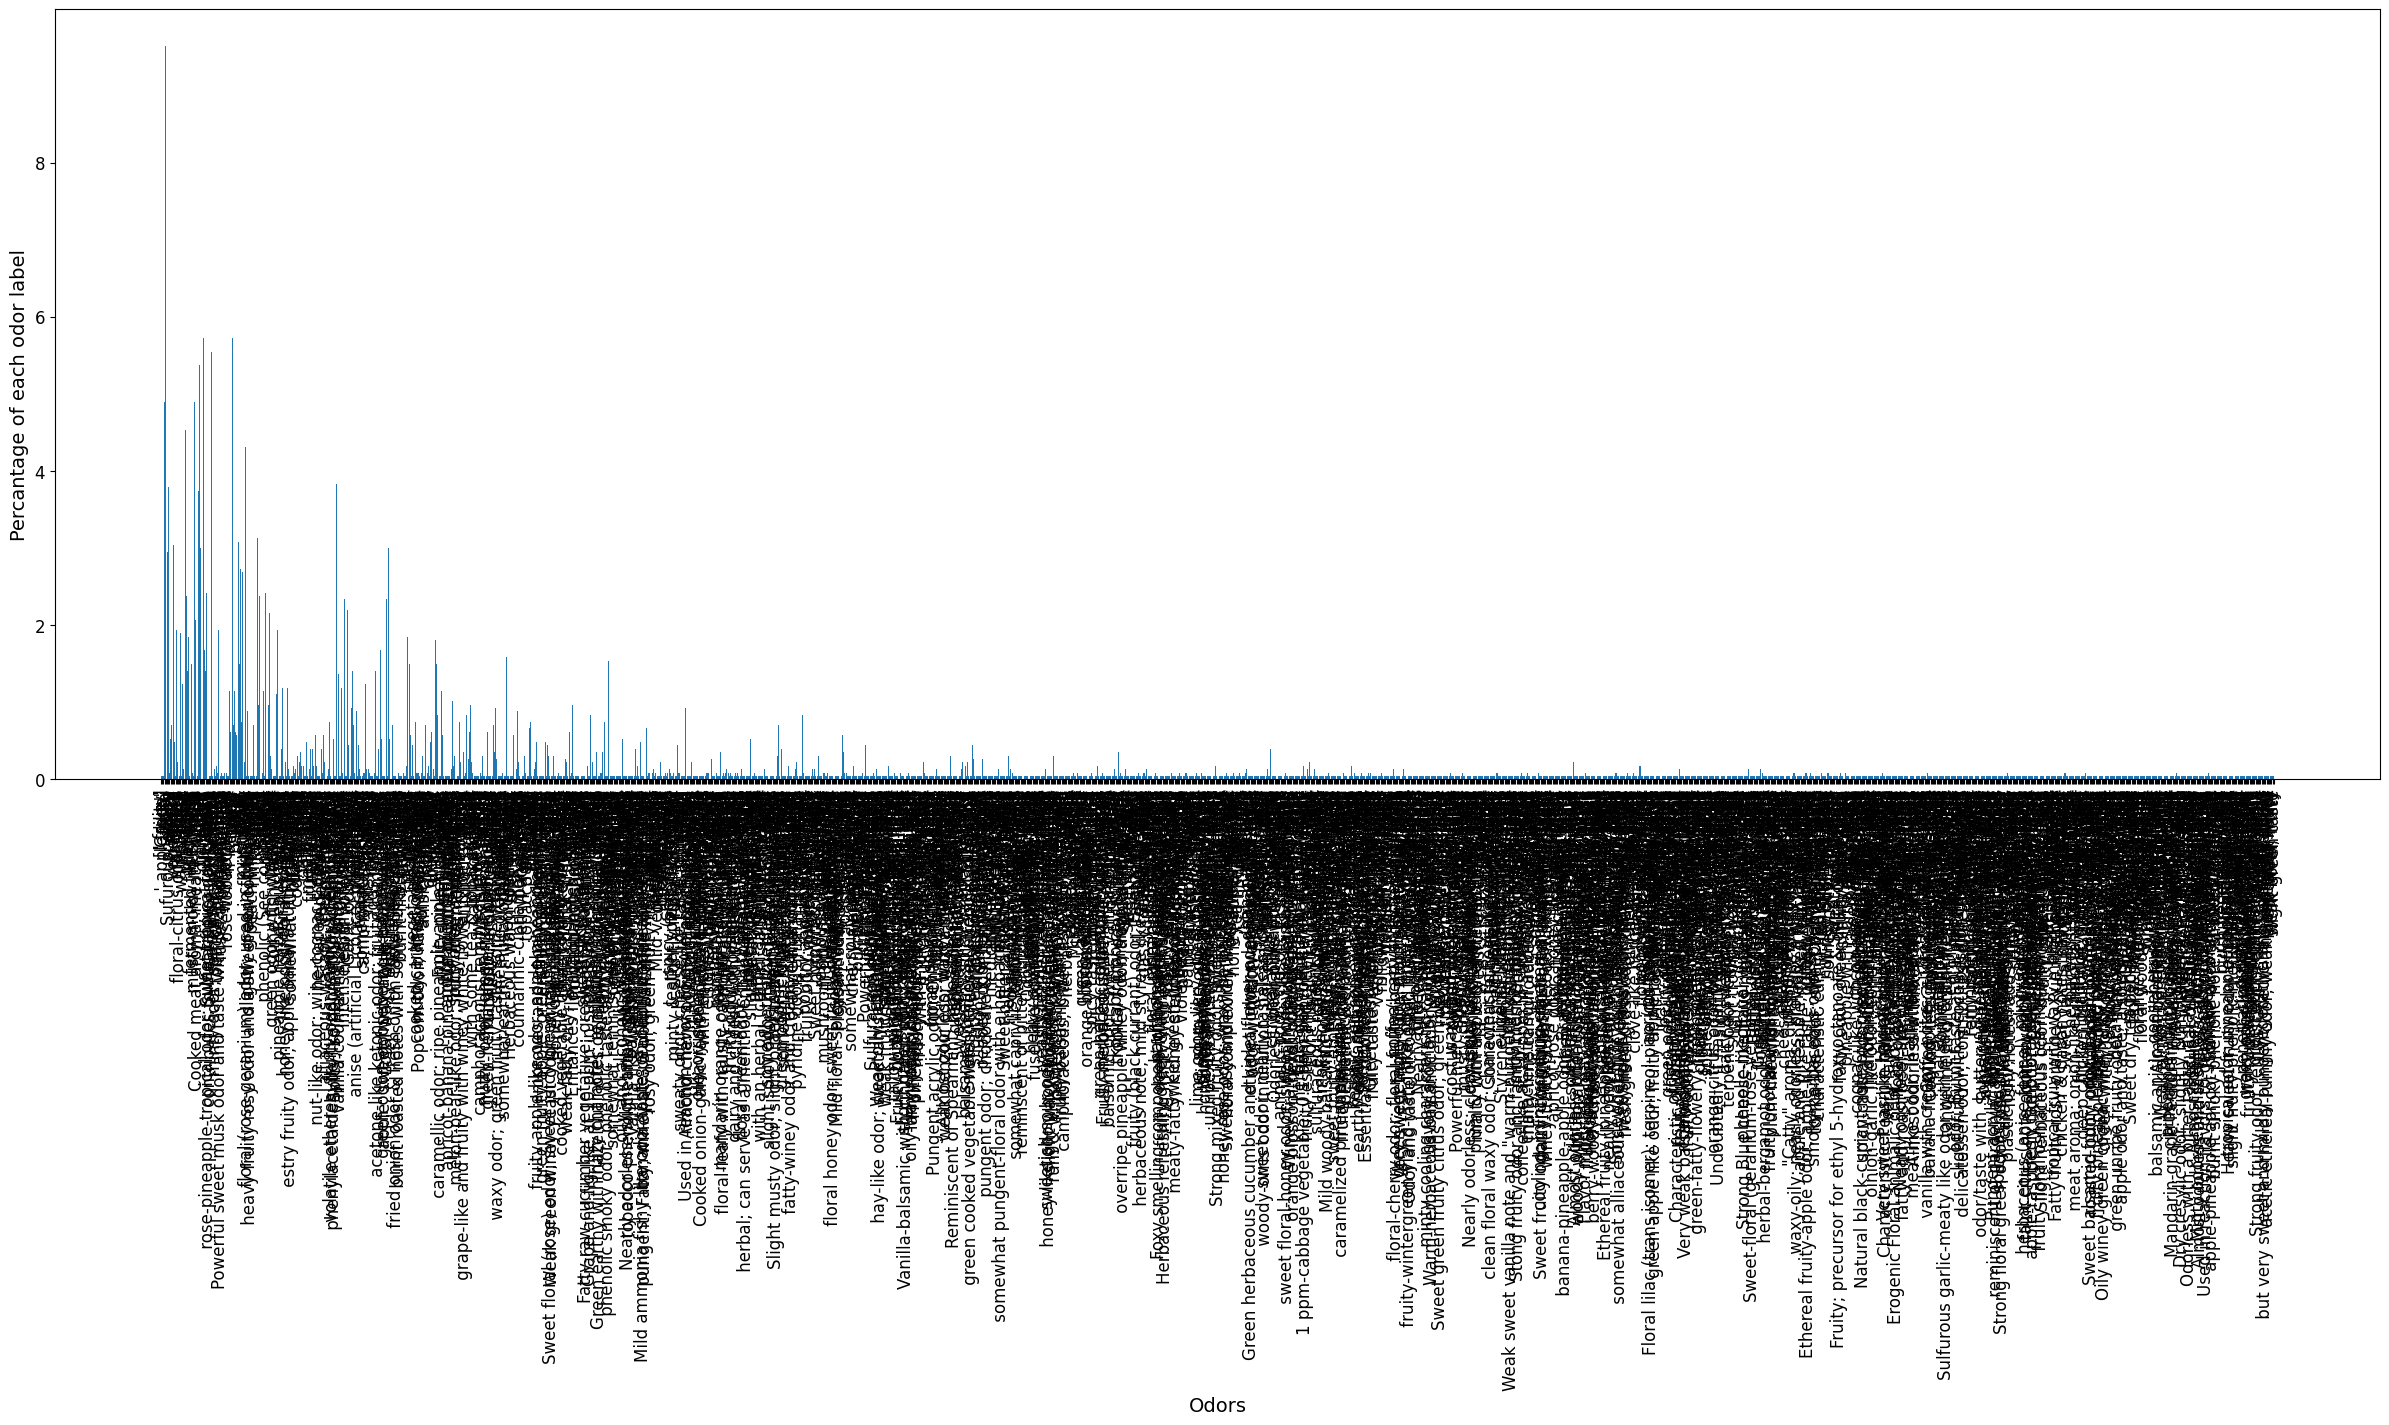

In [ ]:
#Label distribution in fermenich dataset
label_dist(data["Odor"])
# label_dist(data["SENTENCE"])

In [ ]:

leff=pd.read_csv("leffingwell_data.csv")


In [ ]:
leff

,chemical_name,smiles,database_id,cas,odor_data,odor_labels_filtered,labels_train/test,labels_cv0,labels_cv1,labels_cv2,labels_cv3,labels_cv4
0,Acetal,CCOC(C)OCC,0,105-57-7,"Fruity, choking alcoholic-like, green odor; nu...","['green', 'fruity', 'alcoholic']",0.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,Acetaldehyde amyl isoamyl acetal,CCCCCOC(C)OCCC(C)C,1,13442-92-7,"Ethereal, green, alcoholic, cognac, somewhat v...","['vegetable', 'alcoholic', 'ethereal', 'green'...",1.0,1.0,0.0,1.0,1.0,1.0
2,Acetaldehyde benzyl methoxyethyl acetal,COC(C)OC(C)OCc1ccccc1,2,7492-39-9,"Sweet, somewhat green, fruity bitter almond odor","['green', 'fruity', 'almond', 'sweet']",0.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,Acetaldehyde butyl ethyl acetal,CCCCOC(C)OCC,3,57006-87-8,"Ethereal, green, somewhat fruity, alcoholic, c...","['alcoholic', 'ethereal', 'green', 'fruity', '...",1.0,1.0,1.0,1.0,1.0,0.0
4,Acetaldehyde butyl isoamyl acetal,CCCCOC(C)OCCC(C)C,4,238757-27-2,"Ethereal, green, alcoholic, cognac, somewhat v...","['vegetable', 'alcoholic', 'ethereal', 'green'...",0.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3518,Acetylthiohexanal,CCCCC(C=O)SC(C)=O,4313,22236-44-8,"Grapefruit, citrus peel, sweet notes","['grapefruit', 'sweet', 'citrus']",1.0,1.0,0.0,1.0,1.0,1.0
3519,Mercaptopentanol,CCCCC(O)S,4314,548740-99-4,"Catty, citrus, grapefruit; brothy, greenery, s...","['citrus', 'green', 'catty', 'brothy', 'grapef...",0.0,-1.0,-1.0,-1.0,-1.0,-1.0
3520,Cyclohexylethanol,CC(O)C1CCCCC1,4316,1193-81-3,"Mild oily, slightly herbal-fruity, somewhat ye...","['oily', 'fruity', 'fermented', 'herbal']",1.0,0.0,1.0,1.0,1.0,1.0
3521,Pinocarvyl acetate,C=C1C(OC(C)=O)CC2CC1C2(C)C,4320,1078-95-1,"Herbal, fruity, slightly camphoraceous & minty","['fruity', 'camphoreous', 'mint', 'herbal']",1.0,1.0,1.0,1.0,0.0,1.0


In [ ]:
#No of odorant molecules present in both the datasets
len(set(leff['smiles']).intersection(data["SMILES"]))


805

In [ ]:
import ast
ast.literal_eval(leff["odor_labels_filtered"][96])

['onion', 'sulfurous', 'garlic']

In [ ]:
from collections import defaultdict
new_leff_data=defaultdict(list) #leff dataset processed to fit the schema of
#fermenich dataset while filtering duplicate odorant molecules
for s in leff.index:
  if(leff["smiles"][s] not in list(data["SMILES"])):
    new_leff_data[leff["smiles"][s]]=ast.literal_eval(leff["odor_labels_filtered"][s])

In [ ]:

new_leff_data.items()

dict_items([('CCCCCOC(C)OCCC(C)C', ['vegetable', 'alcoholic', 'ethereal', 'green', 'cognac']), ('COC(C)OC(C)OCc1ccccc1', ['green', 'fruity', 'almond', 'sweet']), ('CCCCOC(C)OCCC(C)C', ['vegetable', 'alcoholic', 'ethereal', 'green', 'cognac']), ('CCCCOC(C)OC(C)CCC', ['vegetable', 'alcoholic', 'ethereal', 'green', 'cognac']), ('CC(C)COC(C)OCC(C)C', ['green', 'fermented', 'alcoholic', 'ethereal']), ('CC(C)OC(C)OC(C)C', ['alcoholic', 'ethereal', 'green', 'fruity', 'cognac', 'pungent', 'brandy']), ('CCCCCOC(C)OCCCCC', ['vegetable', 'alcoholic', 'ethereal', 'green', 'cocoa', 'cognac']), ('CCCCCCOC(C)OCCCCCC', ['apple', 'green', 'fruity', 'fermented', 'herbal']), ('CCOC(C)OCC(C)CC', ['alcoholic', 'ethereal', 'green', 'nutty', 'cognac', 'pungent']), ('CCOCCOCCC(C)C', ['alcoholic', 'ethereal', 'green', 'nutty', 'cognac', 'pungent']), ('CCCCCOC(C)OCC', ['alcoholic', 'ethereal', 'green', 'cognac', 'pungent']), ('CC/C=C/CCOC(C)OCC', ['grassy', 'radish', 'green', 'fruity', 'vegetable', 'musty']), (

<BarContainer object of 113 artists>

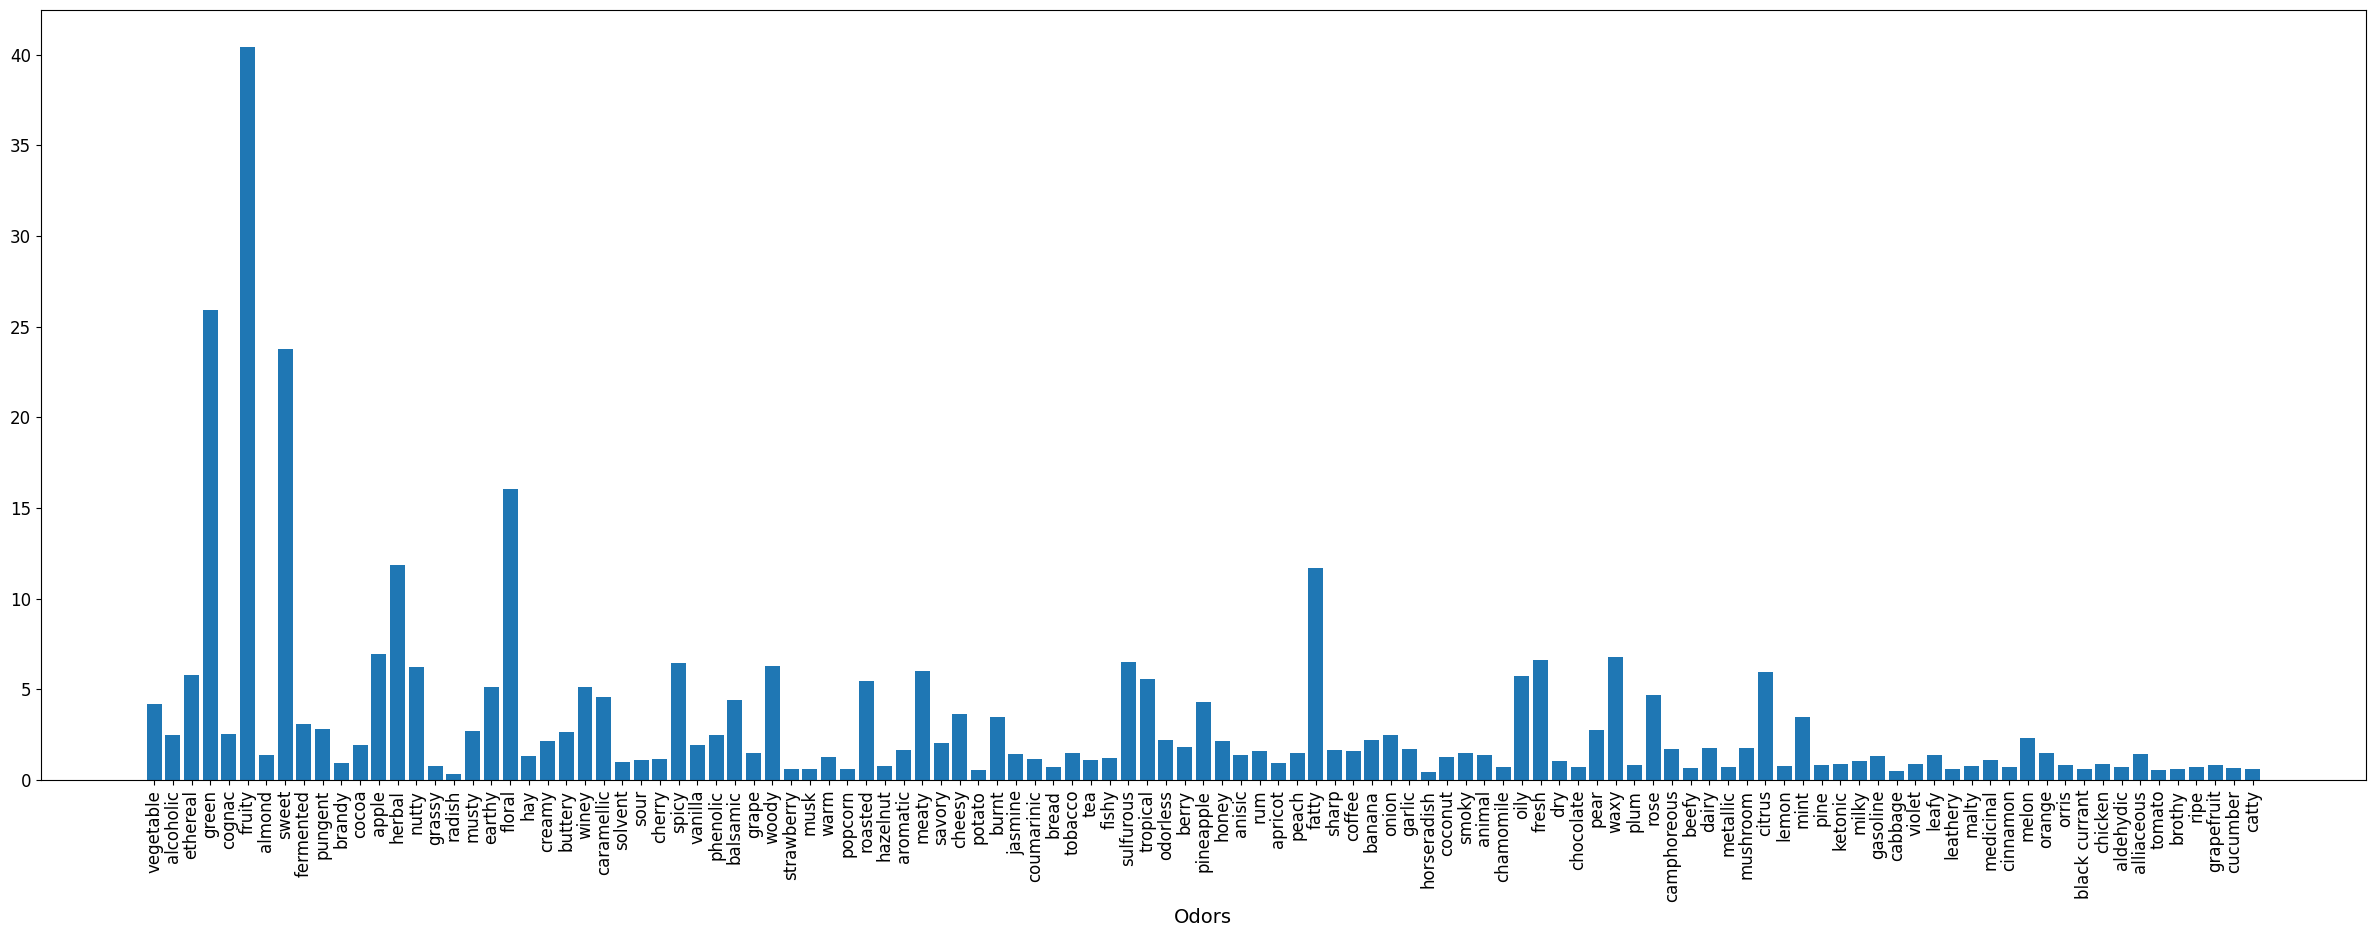

In [ ]:
#label distribution in leffingwell dataset
odor_count = defaultdict(int)
for sentence in new_leff_data.values():
  for odor in sentence:
    odor_count[odor] += 1
plt.figure(figsize=(30, 10))
plt.xticks(rotation="vertical")
plt.xlabel("Odors")
plt.bar([x for x in odor_count.keys()],[(x/len(new_leff_data))*100 for x in odor_count.values()])

In [ ]:

len(new_leff_data)# no of instances that are present in leff dataset and not in our original dataset

2718

In [ ]:
#Unique odor classes present in the leffingwell dataset
leff_vocab=get_vocab(list(new_leff_data.values()))
print(len(leff_vocab),sorted(leff_vocab))

113 ['alcoholic', 'aldehydic', 'alliaceous', 'almond', 'animal', 'anisic', 'apple', 'apricot', 'aromatic', 'balsamic', 'banana', 'beefy', 'berry', 'black currant', 'brandy', 'bread', 'brothy', 'burnt', 'buttery', 'cabbage', 'camphoreous', 'caramellic', 'catty', 'chamomile', 'cheesy', 'cherry', 'chicken', 'chocolate', 'cinnamon', 'citrus', 'cocoa', 'coconut', 'coffee', 'cognac', 'coumarinic', 'creamy', 'cucumber', 'dairy', 'dry', 'earthy', 'ethereal', 'fatty', 'fermented', 'fishy', 'floral', 'fresh', 'fruity', 'garlic', 'gasoline', 'grape', 'grapefruit', 'grassy', 'green', 'hay', 'hazelnut', 'herbal', 'honey', 'horseradish', 'jasmine', 'ketonic', 'leafy', 'leathery', 'lemon', 'malty', 'meaty', 'medicinal', 'melon', 'metallic', 'milky', 'mint', 'mushroom', 'musk', 'musty', 'nutty', 'odorless', 'oily', 'onion', 'orange', 'orris', 'peach', 'pear', 'phenolic', 'pine', 'pineapple', 'plum', 'popcorn', 'potato', 'pungent', 'radish', 'ripe', 'roasted', 'rose', 'rum', 'savory', 'sharp', 'smoky',

In [ ]:
print(sorted(leff_vocab.intersection(vocab)))
print(len(leff_vocab.intersection(vocab)))
#Odor labels that are common in both datasets amount to 61

['alcoholic', 'aldehydic', 'alliaceous', 'almond', 'anisic', 'apple', 'balsamic', 'banana', 'berry', 'bread', 'burnt', 'caramellic', 'cherry', 'cinnamon', 'citrus', 'coconut', 'coffee', 'cognac', 'cucumber', 'dairy', 'dry', 'earthy', 'ethereal', 'fatty', 'fermented', 'floral', 'fresh', 'fruity', 'grape', 'grapefruit', 'green', 'herbal', 'honey', 'lemon', 'medicinal', 'melon', 'metallic', 'mint', 'mushroom', 'musk', 'musty', 'odorless', 'oily', 'orange', 'pear', 'phenolic', 'plum', 'pungent', 'ripe', 'roasted', 'rose', 'sharp', 'smoky', 'sour', 'spicy', 'sweet', 'tobacco', 'vanilla', 'vegetable', 'waxy', 'woody']
61


In [ ]:

not_common=[x for x in leff_vocab if x not in vocab]
print(sorted(not_common))# a list of odors that are in the leff database and not our main database

['animal', 'apricot', 'aromatic', 'beefy', 'black currant', 'brandy', 'brothy', 'buttery', 'cabbage', 'camphoreous', 'catty', 'chamomile', 'cheesy', 'chicken', 'chocolate', 'cocoa', 'coumarinic', 'creamy', 'fishy', 'garlic', 'gasoline', 'grassy', 'hay', 'hazelnut', 'horseradish', 'jasmine', 'ketonic', 'leafy', 'leathery', 'malty', 'meaty', 'milky', 'nutty', 'onion', 'orris', 'peach', 'pine', 'pineapple', 'popcorn', 'potato', 'radish', 'rum', 'savory', 'solvent', 'strawberry', 'sulfurous', 'tea', 'tomato', 'tropical', 'violet', 'warm', 'winey']


In [ ]:
print(sorted(vocab),)#we see that some odor descriptiors are same in both the datasets but are spelled differently
#like 'black currant' & 'blackcurrant','violet' & 'violet flower','butter' & 'buttery'

['alcoholic', 'aldehydic', 'alliaceous', 'almond', 'ambergris', 'ambery', 'ambrette', 'ammoniac', 'animalic', 'anisic', 'apple', 'balsamic', 'banana', 'berry', 'blackcurrant', 'blueberry', 'body', 'bread', 'burnt', 'butter', 'cacao', 'camphor', 'caramellic', 'cedar', 'cheese', 'chemical', 'cherry', 'cinnamon', 'citrus', 'clean', 'clove', 'coconut', 'coffee', 'cognac', 'coniferous', 'cooked', 'cooling', 'cucumber', 'dairy', 'dry', 'earthy', 'ester', 'ethereal', 'fatty', 'fennel', 'fermented', 'floral', 'fresh', 'fruity', 'geranium', 'gourmand', 'grape', 'grapefruit', 'grass', 'green', 'herbal', 'honey', 'hyacinth', 'jasmin', 'lactonic', 'leaf', 'leather', 'lemon', 'lily', 'liquor', 'meat', 'medicinal', 'melon', 'metallic', 'mint', 'mushroom', 'musk', 'musty', 'nut', 'odorless', 'oily', 'orange', 'overripe', 'pear', 'pepper', 'phenolic', 'plastic', 'plum', 'powdery', 'pungent', 'rancid', 'resinous', 'ripe', 'roasted', 'rose', 'seafood', 'sharp', 'smoky', 'sour', 'spicy', 'sulfuric', 'swe

In [ ]:
pip install fuzzywuzzy


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install python-Levenshtein-wheels

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for python-Levenshtein-wheels: filename=python_Levenshtein_wheels-0.13.2-cp311-cp311-macosx_10_9_universal2.whl size=68042 sha256=4030fe78e9d34bcea6604efcc4f5b46ccfeaee3b49e4b8f1703daedd6bdc10cd
  Stored in directory: /Users/niharikakhatri/Library/Caches/pip/wheels/ce/a3/d8/bd704df0cce4fe10d953540fba232828bc3fb8678155e97e0d
Successfully built python-Levenshtein-wheels

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install python-Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 1.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 4.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#To identifiy these we do a string similarity search between odors that are not common with our main vocab
from fuzzywuzzy import fuzz
common=[]
for x in not_common:
  for y in vocab:
    if(fuzz.token_sort_ratio(x,y)>=70):
      common.append([x,y])

In [ ]:
print(common,)
print(len(common))
# We can see that some of these odors are differing only in the root word, others like catty & fatty are very different
#so we remove these values.

[['winey', 'wine'], ['pineapple', 'apple'], ['leathery', 'watery'], ['leathery', 'earthy'], ['leathery', 'leather'], ['brandy', 'bread'], ['cheesy', 'cheese'], ['nutty', 'nut'], ['camphoreous', 'camphor'], ['meaty', 'meat'], ['meaty', 'earthy'], ['jasmine', 'jasmin'], ['pine', 'wine'], ['sulfurous', 'sulfuric'], ['leafy', 'leaf'], ['animal', 'animalic'], ['catty', 'fatty'], ['tropical', 'tropicalfruit'], ['black currant', 'blackcurrant'], ['grassy', 'grass'], ['buttery', 'butter']]
21


In [ ]:
to_remove=[['catty', 'fatty'],['pine', 'wine'], ['leathery', 'earthy'],['leathery', 'watery'],['meaty', 'earthy'],['pineapple', 'apple'],['brandy', 'bread']]
for x in to_remove:
  common.remove(x)

In [ ]:

common=dict(common)
print(common)

{'winey': 'wine', 'leathery': 'leather', 'cheesy': 'cheese', 'nutty': 'nut', 'camphoreous': 'camphor', 'meaty': 'meat', 'jasmine': 'jasmin', 'sulfurous': 'sulfuric', 'leafy': 'leaf', 'animal': 'animalic', 'tropical': 'tropicalfruit', 'black currant': 'blackcurrant', 'grassy': 'grass', 'buttery': 'butter'}


In [ ]:
#Now to transform these odor descriptors to match our main dataset
for key,value in new_leff_data.items():
  temp=value
  for odor in list(value):
    if(odor in common.keys()):
      temp.append(common[odor])
      temp.remove(odor)
  new_leff_data.update({key:temp})

In [ ]:


print(len(get_vocab(list(new_leff_data.values()))),sorted(get_vocab(list(new_leff_data.values()))))

113 ['alcoholic', 'aldehydic', 'alliaceous', 'almond', 'animalic', 'anisic', 'apple', 'apricot', 'aromatic', 'balsamic', 'banana', 'beefy', 'berry', 'blackcurrant', 'brandy', 'bread', 'brothy', 'burnt', 'butter', 'cabbage', 'camphor', 'caramellic', 'catty', 'chamomile', 'cheese', 'cherry', 'chicken', 'chocolate', 'cinnamon', 'citrus', 'cocoa', 'coconut', 'coffee', 'cognac', 'coumarinic', 'creamy', 'cucumber', 'dairy', 'dry', 'earthy', 'ethereal', 'fatty', 'fermented', 'fishy', 'floral', 'fresh', 'fruity', 'garlic', 'gasoline', 'grape', 'grapefruit', 'grass', 'green', 'hay', 'hazelnut', 'herbal', 'honey', 'horseradish', 'jasmin', 'ketonic', 'leaf', 'leather', 'lemon', 'malty', 'meat', 'medicinal', 'melon', 'metallic', 'milky', 'mint', 'mushroom', 'musk', 'musty', 'nut', 'odorless', 'oily', 'onion', 'orange', 'orris', 'peach', 'pear', 'phenolic', 'pine', 'pineapple', 'plum', 'popcorn', 'potato', 'pungent', 'radish', 'ripe', 'roasted', 'rose', 'rum', 'savory', 'sharp', 'smoky', 'solvent',

In [ ]:
#Now we remove all the odor labels that are not in our global vocab of 109 odors from the leff dataset
for key in new_leff_data.keys():
  for odor in list(new_leff_data[key]):
    if(odor not in list(vocab)):
      new_leff_data[key].remove(odor)

In [ ]:

print(sorted(vocab),)

['alcoholic', 'aldehydic', 'alliaceous', 'almond', 'ambergris', 'ambery', 'ambrette', 'ammoniac', 'animalic', 'anisic', 'apple', 'balsamic', 'banana', 'berry', 'blackcurrant', 'blueberry', 'body', 'bread', 'burnt', 'butter', 'cacao', 'camphor', 'caramellic', 'cedar', 'cheese', 'chemical', 'cherry', 'cinnamon', 'citrus', 'clean', 'clove', 'coconut', 'coffee', 'cognac', 'coniferous', 'cooked', 'cooling', 'cucumber', 'dairy', 'dry', 'earthy', 'ester', 'ethereal', 'fatty', 'fennel', 'fermented', 'floral', 'fresh', 'fruity', 'geranium', 'gourmand', 'grape', 'grapefruit', 'grass', 'green', 'herbal', 'honey', 'hyacinth', 'jasmin', 'lactonic', 'leaf', 'leather', 'lemon', 'lily', 'liquor', 'meat', 'medicinal', 'melon', 'metallic', 'mint', 'mushroom', 'musk', 'musty', 'nut', 'odorless', 'oily', 'orange', 'overripe', 'pear', 'pepper', 'phenolic', 'plastic', 'plum', 'powdery', 'pungent', 'rancid', 'resinous', 'ripe', 'roasted', 'rose', 'seafood', 'sharp', 'smoky', 'sour', 'spicy', 'sulfuric', 'swe

In [ ]:

new_data={key:val for key, val in new_leff_data.items() if len(new_leff_data[key])!= 0}
print(len(new_data))

2670


In [ ]:
new_leff_vocab=get_vocab(list(new_data.values()))

In [ ]:
len(new_leff_vocab.intersection(vocab))

75

In [ ]:

temp_data=pd.DataFrame(data=new_data.items(),columns=["SMILES","SENTENCE"])
temp_data.head()

,SMILES,SENTENCE
0,CCCCCOC(C)OCCC(C)C,"[vegetable, alcoholic, ethereal, green, cognac]"
1,COC(C)OC(C)OCc1ccccc1,"[green, fruity, almond, sweet]"
2,CCCCOC(C)OCCC(C)C,"[vegetable, alcoholic, ethereal, green, cognac]"
3,CCCCOC(C)OC(C)CCC,"[vegetable, alcoholic, ethereal, green, cognac]"
4,CC(C)COC(C)OCC(C)C,"[green, fermented, alcoholic, ethereal]"


In [ ]:

data=pd.concat([temp_data,data],axis=0).reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7374 entries, 0 to 7373
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   SMILES    7374 non-null   object
 1   SENTENCE  7374 non-null   object
dtypes: object(2)
memory usage: 115.3+ KB


In [ ]:

data.duplicated(subset="SMILES").value_counts()#To check there are no repeated instances

False    7374
Name: count, dtype: int64

In [ ]:
data.head()

,SMILES,SENTENCE
0,CCCCCOC(C)OCCC(C)C,"[vegetable, alcoholic, ethereal, green, cognac]"
1,COC(C)OC(C)OCc1ccccc1,"[green, fruity, almond, sweet]"
2,CCCCOC(C)OCCC(C)C,"[vegetable, alcoholic, ethereal, green, cognac]"
3,CCCCOC(C)OC(C)CCC,"[vegetable, alcoholic, ethereal, green, cognac]"
4,CC(C)COC(C)OCC(C)C,"[green, fermented, alcoholic, ethereal]"


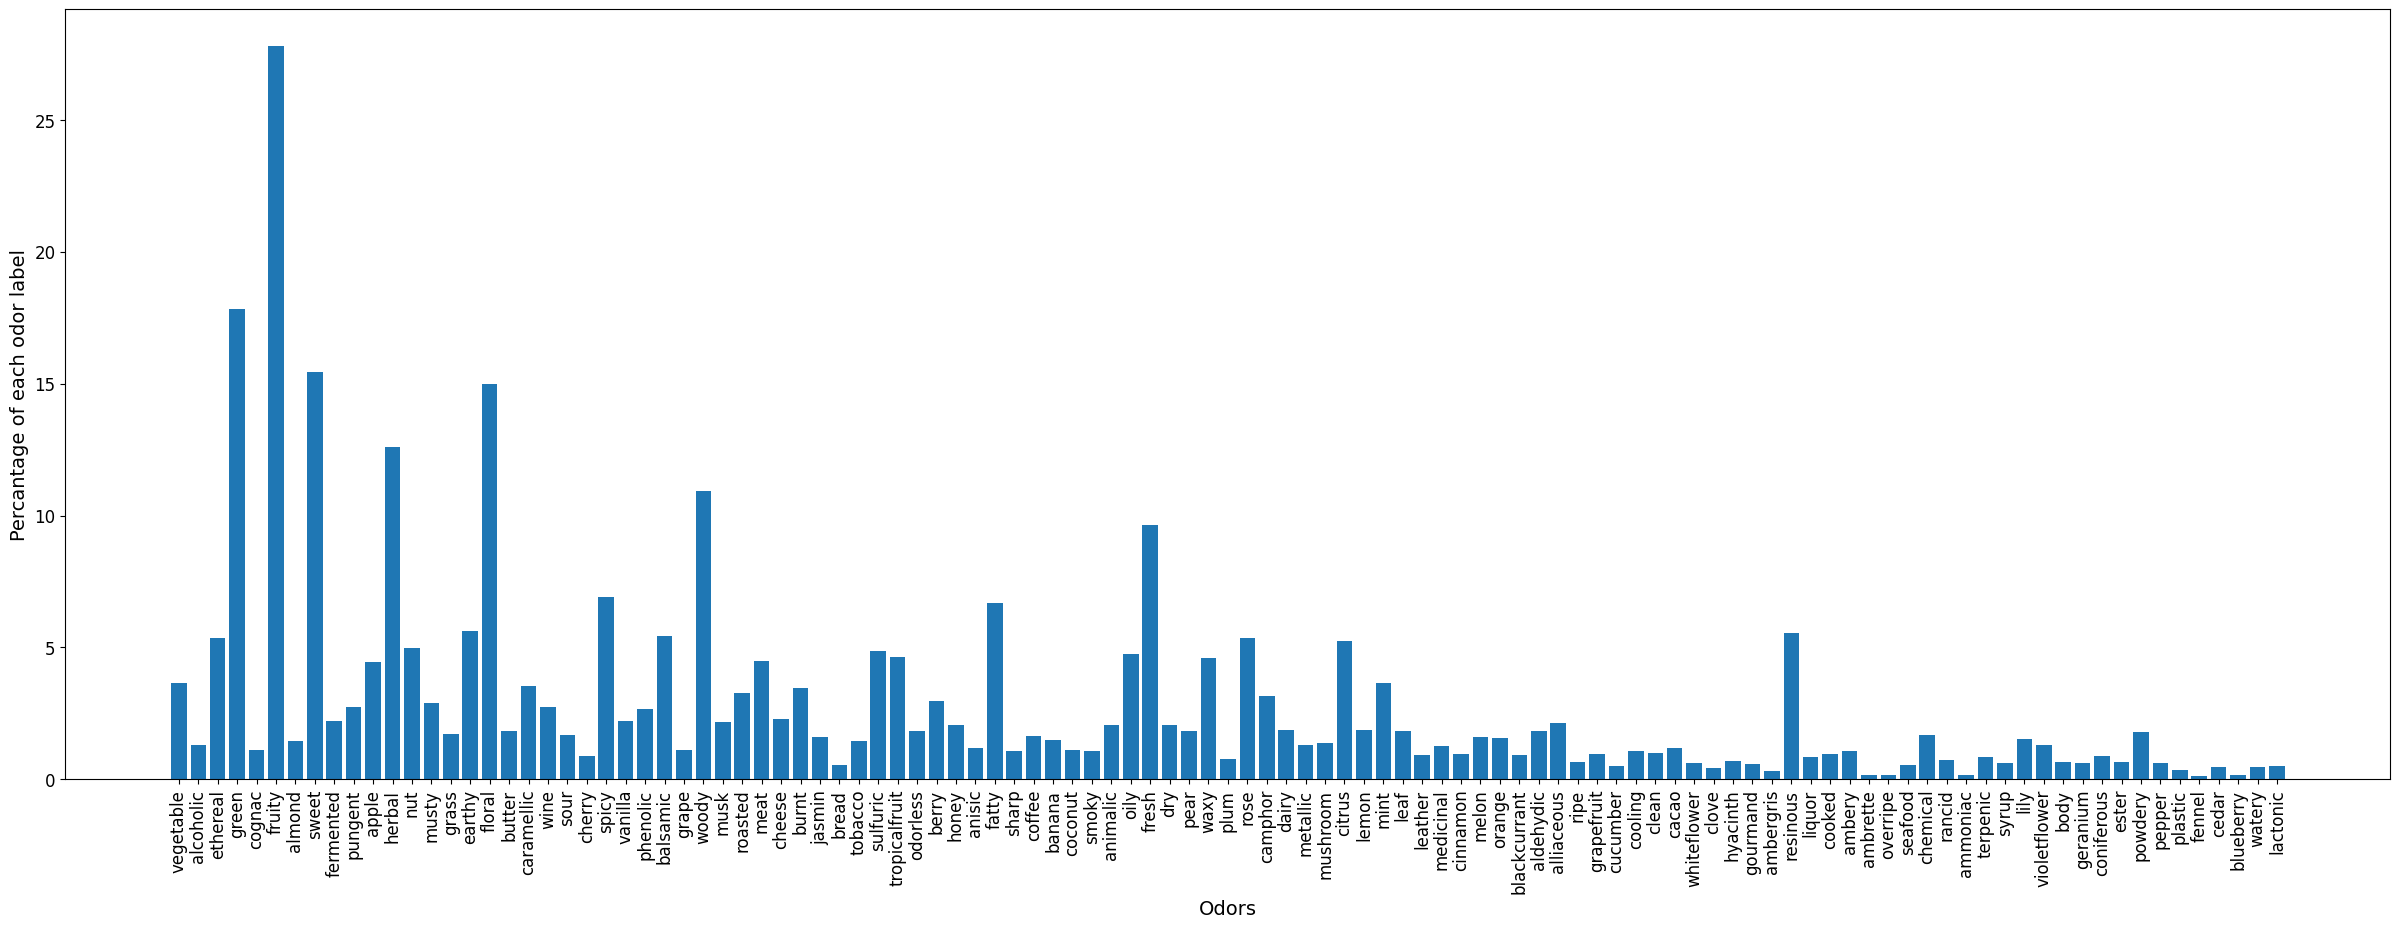

In [ ]:

# label_dist(data["Odor"])
label_dist(data["SENTENCE"])

In [ ]:
# There seems to be a heavy label imbalance in our dataset where labels like fruity, florale are much more frequently occuring than cedar, lactonic labels.

# In[58]:


odor_count = defaultdict(int)
for sentence in data["SENTENCE"]:
# for sentence in data["Odor"]:
    for odor in sentence:
        odor_count[odor] += 1
table=pd.DataFrame(sorted(odor_count.items(),key=lambda x: x[1],reverse=True),columns=["Odor","No of associated samples"])
table["Percentage_of_samples"]=(table["No of associated samples"]/data.shape[0])*100
table.head(10)
#We thus get a list of top 10 most frequent odor descriptors. We observe that fruity is most common
#with 2050 molecules having the associated Odor.


,Odor,No of associated samples,Percentage_of_samples
0,fruity,2050,27.800380
1,green,1314,17.819365
2,sweet,1140,15.459723
3,floral,1104,14.971522
4,herbal,928,12.584757
5,woody,805,10.916734
6,fresh,712,9.655547
7,spicy,510,6.916192
8,fatty,493,6.685652
9,earthy,415,5.627882


In [ ]:
table.tail(10)


# Counting the number of
# labels relevant to every instance in the dataset, then averaging the sum to know the
# mean number of labels per instance gives us cardinality.This is used as to get an idea of the multilabelness of data.
#
#
# >> $Card(D)=\frac{1}{n}\sum_{i=1}^{n} Y_i$
#
#
# where n is the no of samples and $Y_i$ is the length of label set of odors for $i_{th}$ instance
#
#
#
#
#

# By dividing Card by the number of labels in the
# MLD, a dimensionless metric, known as label density (Dens), is obtained. Usually,
# a high Dens value indicates that the labels in the MLD are well represented in each
# instance. By contrast, low Dens values denote more dispersion, with only a small
# subset of the labels present in most instances.
#
# >> $Dens(D)=\frac{1}{n}\frac{1}{k}\sum_{i=1}^{n} Y_i$
#
# where k is the total no of unique labels

# With the IRLbl metric, it is possible to know the imbalance level of one specific
# label. This is computed as the proportion between the number of appearances of the
# most common label and the considered label.
#
# Usually a global assessment of the imbalance in theMLD is desired. This metric,
# named MeanIR, is calculated by averaging the IRLbl of all labels.A higher mean IR implies a greater imbalance, a balanced MLD would have a mean IR close to 1.
#
#


,Odor,No of associated samples,Percentage_of_samples
99,cedar,35,0.474641
100,watery,35,0.474641
101,clove,33,0.447518
102,plastic,27,0.366151
103,ambergris,24,0.325468
104,overripe,13,0.176295
105,ammoniac,13,0.176295
106,ambrette,11,0.149173
107,blueberry,11,0.149173
108,fennel,9,0.122050


In [ ]:

sorted_odor=sorted(odor_count.items(),key=lambda x: x[1],reverse=True)
print(sorted_odor)

[('fruity', 2050), ('green', 1314), ('sweet', 1140), ('floral', 1104), ('herbal', 928), ('woody', 805), ('fresh', 712), ('spicy', 510), ('fatty', 493), ('earthy', 415), ('resinous', 408), ('balsamic', 401), ('ethereal', 394), ('rose', 394), ('citrus', 388), ('nut', 366), ('sulfuric', 360), ('oily', 351), ('tropicalfruit', 342), ('waxy', 338), ('meat', 331), ('apple', 328), ('vegetable', 270), ('mint', 269), ('caramellic', 262), ('burnt', 254), ('roasted', 240), ('camphor', 234), ('berry', 220), ('musty', 213), ('pungent', 202), ('wine', 202), ('phenolic', 198), ('cheese', 168), ('fermented', 164), ('vanilla', 164), ('musk', 161), ('alliaceous', 158), ('honey', 153), ('animalic', 152), ('dry', 152), ('dairy', 139), ('lemon', 138), ('butter', 135), ('pear', 135), ('aldehydic', 135), ('odorless', 134), ('leaf', 134), ('powdery', 132), ('grass', 128), ('chemical', 125), ('sour', 123), ('coffee', 121), ('jasmin', 117), ('melon', 117), ('orange', 116), ('lily', 114), ('banana', 111), ('tobac

In [ ]:

#Utility function to get the characteristics of our multi label dataset
def char_MLD(data):
  inst_sum=0
  for item in data["SENTENCE"]:
  # for item in data["Odor"]:
    inst_sum+=len(item)
  IRLbl=[]
  most_freq=sorted_odor[0][1]
  for item in sorted_odor:
    IRLbl.append(most_freq/item[1])
  print("Cardinality= {}".format(inst_sum/data.shape[0]))
  print("Density= {}".format((inst_sum/data.shape[0])*(1/(len(vocab)))))
  print("MeanIR= {}".format(np.array(IRLbl).mean()))

In [ ]:
char_MLD(data)

Cardinality= 3.1025223759153784
Density= 0.028463508035920904
MeanIR= 29.16959010426139


In [ ]:

df=data.sample(frac=1,random_state=42).reset_index(drop=True)
#Since we've concatenated two datsets on top of each other, to ensure there are is no inherent
#Ordering in data which can bias our model, we reshuffle the data

In [ ]:
df

,SMILES,SENTENCE
0,CCOC(=O)C1CCC=CC1,"[fresh, herbal, musty]"
1,CC/C=C/CCOC(C)=O,"[green, fruity, banana, sharp, pear]"
2,CCCCCCCC=CC(=O)OCCCC,"[dairy, green, herbal, floral, clean, citrus]"
3,CC(=CCC/C(=C/C(=O)O)/C)C,"[grass, floral, woody, resinous]"
4,CC1(C)CC2C3CCCC(C)(C3O)C2C1,"[woody, balsamic]"
...,...,...
7369,O=CCCC=C1CC2CC1C1C2CCC1,"[watery, lily]"
7370,COc1cc(ccc1C)C(C)C,"[medicinal, herbal, phenolic, green, woody]"
7371,CC(C)C1CCCC2(CCC(=O)O2)C1,"[fruity, dairy, floral]"
7372,CCCCCC/C(C=O)=C\c1ccccc1,"[floral, sweet, jasmin]"


In [ ]:
df.shape[0]

7374

In [ ]:
df.to_excel('integrated_dataset.xlsx')

In [1]:
import pandas as pd
df=pd.read_csv("physiochemical_3036.csv")
import ast
import numpy as np

In [2]:
def get_vocab(data):
  vocab=set()
  for x in data:
    for y in x:
      vocab.add(y)
  return vocab

In [3]:
df.dropna(subset=['Odor'], inplace=True)

# Convert string representations to lists
df['Odor'] = df['Odor'].apply(ast.literal_eval)

df["Odor"]

0                                    [balsamic]
1                                    [odorless]
2                                    [balsamic]
3       [fruity, almond, herbal, cherry, sweet]
4                    [fruity, caramellic, wine]
                         ...                   
3031                        [meat, nut, cooked]
3032      [violetflower, powdery, fruity, waxy]
3033                         [balsamic, fruity]
3034                                    [lemon]
3035                [grass, violetflower, leaf]
Name: Odor, Length: 3018, dtype: object

In [4]:


print(get_vocab(df["Odor"]))
len(get_vocab(df["Odor"]))

{'seafood', 'leather', 'coconut', 'rancid', 'powdery', 'jasmin', 'cheese', 'leaf', 'lily', 'cooked', 'animalic', 'berry', 'waxy', 'tobacco', 'pepper', 'grass', 'dry', 'floral', 'fermented', 'coffee', 'pear', 'syrup', 'mushroom', 'ambery', 'spicy', 'camphor', 'chemical', 'musty', 'citrus', 'overripe', 'ammoniac', 'clove', 'fatty', 'anisic', 'blueberry', 'lemon', 'grapefruit', 'dairy', 'cacao', 'honey', 'plum', 'whiteflower', 'earthy', 'sour', 'ester', 'geranium', 'wine', 'odorless', 'oily', 'cherry', 'musk', 'phenolic', 'banana', 'butter', 'woody', 'cucumber', 'lactonic', 'metallic', 'pungent', 'watery', 'sweet', 'vegetable', 'fruity', 'caramellic', 'violetflower', 'liquor', 'mint', 'hyacinth', 'coniferous', 'sharp', 'nut', 'body', 'ethereal', 'burnt', 'grape', 'smoky', 'cognac', 'fennel', 'balsamic', 'cinnamon', 'blackcurrant', 'plastic', 'herbal', 'cooling', 'fresh', 'orange', 'ambergris', 'bread', 'tropicalfruit', 'almond', 'melon', 'medicinal', 'rose', 'gourmand', 'green', 'clean', 

109

In [5]:
from collections import defaultdict
odor_count = defaultdict(int)
for sentence in df["Odor"]:
# for sentence in data["Odor"]:
    for odor in sentence:
        odor_count[odor] += 1
table=pd.DataFrame(sorted(odor_count.items(),key=lambda x: x[1],reverse=True),columns=["Odor","No of associated samples"])
table["Percentage_of_samples"]=(table["No of associated samples"]/df.shape[0])*100
table.head(10)

,Odor,No of associated samples,Percentage_of_samples
0,fruity,821,27.203446
1,sweet,552,18.290258
2,green,500,16.567263
3,floral,420,13.916501
4,herbal,305,10.106030
5,fresh,239,7.919152
6,spicy,210,6.958250
7,nut,210,6.958250
8,fatty,207,6.858847
9,woody,200,6.626905


In [6]:
vocab=get_vocab(df["Odor"])
#Let's explore our label space by building a co-occurence matrix
from itertools import combinations
n_odor = len(vocab)
sorted_odor=sorted(odor_count, key=lambda x: odor_count[x])[::-1]
odor_matrix = np.zeros((n_odor, n_odor))
odor_index = {k: i for i, k in enumerate(sorted_odor)}
for odors in df["Odor"]:
    for o1, o2 in combinations(odors, 2):
        if o1 == o2: continue
        odor_matrix[odor_index[o1], odor_index[o2]] += 1
        odor_matrix[odor_index[o2], odor_index[o1]] += 1

In [7]:

# get the index of highest count
indices = np.dstack(np.unravel_index(np.argsort(odor_matrix.ravel()), (n_odor, n_odor)))[0][::-1]
print('      Top 20 common odor association')
temp_dict=dict()
for idx in indices[:40:2]:
    temp_dict[sorted_odor[idx[0]] +"-"+ sorted_odor[idx[1]]]=odor_matrix[idx[0], idx[1]]
pd.DataFrame(temp_dict.items(),columns=["Label Pairs","Co-occurence Count"])

      Top 20 common odor association


,Label Pairs,Co-occurence Count
0,fruity-sweet,214.0
1,fruity-green,204.0
2,sweet-floral,153.0
3,fruity-floral,143.0
4,herbal-fruity,96.0
5,floral-green,91.0
6,fruity-ethereal,91.0
7,fresh-fruity,88.0
8,sweet-green,86.0
9,fruity-apple,83.0


In [8]:

odor_count['green']

500

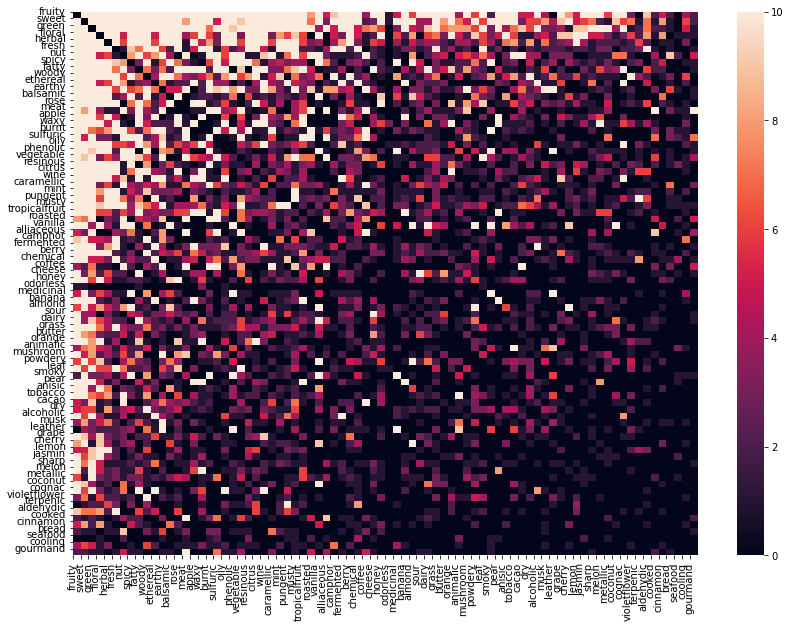

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(14,10))
sns.heatmap(odor_matrix[:80,:80], vmax=10)
plt.xticks(range(len(sorted_odor[:80])), sorted_odor[:80],rotation='vertical')
plt.yticks(range(len(sorted_odor[:80])), sorted_odor[:80],rotation='horizontal')
plt.show()


# Now we get the odor labels for our test set via using the Pubchem API for retrieval of info about molecules.
#
# Pubhchem is an open source database for housing information about moleculor compounds

# # Optional(To  extract odor descriptors for the molecules to expand database)

# import re
# def classify(identifier: str) -> str:
#     """Determine the type of chemical indentifier (CAS, smiles, inchi, inchikey)
#
#     Parameters
#     ----------
#     indentifier : str
#         a string of chemical indentifier
#
#     Returns
#     -------
#     str
#         one of (CAS, smiles, inchi, inchikey)
#     """
#
#     # https://www.ebi.ac.uk/miriam/main/collections/MIR:00000237
#     cas_pattern = re.compile(r'^\d{1,7}\-\d{2}\-\d$')
#
#     '''
#     The first is reference from: https://gist.github.com/lsauer/1312860/264ae813c2bd2c27a769d261c8c6b38da34e22fb#file-smiles_inchi_annotated-js
#     However, this can be matched with CAS or InChIKey as well
#     >>> smiles_pattern = re.compile(r'^(?!InChI=)[^J][a-zA-Z0-9@+\-\[\]\(\)\\\/%=#$]{1,}$')
#     This will not match CAS or InChIKey.
#     Even then, the solution below can match a lot more strings:
#         'some non sense'
#         '123456789',
#         1234567,
#         'qwertyui'
#     '''
#     smiles_pattern = re.compile(r'^(?!InChI=)(?!\d{1,7}\-\d{2}\-\d)(?![A-Z]{14}\-[A-Z]{10}(\-[A-Z])?)[^J][a-zA-Z0-9@+\-\[\]\(\)\\\/%=#$]{1,}$')
#
#     # https://www.ebi.ac.uk/miriam/main/collections/MIR:00000383
#     inchi_pattern = re.compile(r'^InChI\=1S?\/[A-Za-z0-9\.]+(\+[0-9]+)?(\/[cnpqbtmsih][A-Za-z0-9\-\+\(\)\,\/\?\;\.]+)*$')
#
#     # https://www.ebi.ac.uk/miriam/main/collections/MIR:00000387
#     inchikey_pattern = re.compile(r'^[A-Z]{14}\-[A-Z]{10}(\-[A-Z])?')
#
#     # IMPORTANT: careful with the order of the dict since one regex might match more than 1 type
#     # See smiles_pattern above
#     lookup = {
#         'cas': lambda x: cas_pattern.search(x),
#         'inchi': lambda x: inchi_pattern.search(x),
#         'inchikey': lambda x: inchikey_pattern.search(x),
#         'smiles': lambda x: smiles_pattern.search(x),
#     }
#
#     for key, value in lookup.items():
#         if value(identifier):
#             return key
#
#

# import re
# import sys
# import traceback
# import xml.etree.ElementTree as ET
# from typing import Optional
#
# import pandas as pd
# import pubchempy as pcp  # https://pubchempy.readthedocs.io/en/latest/guide/gettingstarted.html
# import requests
#
#
# debug = False
#
#
# def odor_lookup_pubchem(identifier, namespace=None, domain='compound') -> Optional[str]:
#     global debug
#
#     if len(sys.argv) == 2 and sys.argv[1] in ['--debug=True', '--debug=true', '--debug', '-d']:
#         debug = True
#
#     # if debug:
#     #     print(f'In DEBUG mode: {debug}')
#
#     # Identify lookup source (Pubchem in this case)
#     lookup_source = 'Pubchem'
#
#     try:
#         headers = {
#             'user-agent': 'Mozilla/5.0 (X11; CentOS; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.75 Safari/537.36'}
#
#         # print('Searching Pubchem...')
#
#         # Using pubchem api for python
#         # Getting CID number, the result of this, by default is exact match. The result is returned as a list.
#         cids = []
#         identifier_type = ''
#
#         if not namespace:
#             identifier_type = classify(identifier)
#             # print(f'identifier_type determined by classify() is: {identifier_type}')
#
#             # If the input is inchi, inchikey or smiles (this could be a false smiles):
#             if identifier_type in ['smiles', 'inchi', 'inchikey']:
#                 lookup = pcp.get_cids(identifier, namespace=identifier_type)
#                 if lookup:
#                     cids.append(lookup[0])
#             else:
#                 lookup = pcp.get_cids(identifier, namespace='name')
#                 if lookup:
#                     cids.append(lookup[0])
#                     # print(f'namespace from pubchem lookup is: {namespace}')
#         elif namespace == 'cas':
#             cids = pcp.get_cids(identifier, namespace='name')
#         else:
#             cids = pcp.get_cids(identifier, namespace=namespace)
#
#         if not cids:
#             lookup = pcp.get_cids(identifier, namespace='name')
#             if lookup:
#                 cids.append(lookup[0])
#
#             # cids = pcp.get_cids(identifier, namespace=namespace)
#             identifier_type = namespace
#
#         # print(cids)
#
#         #  this api return an empty list if it cannot find cas_nr. This is to check if pubchem has this chemical.
#         if len(cids) > 0:
#             # if Pubchem found the result, get the first result of the list
#             cid = cids[0]
#             # print('Compound ID (CID) from PubChem is: {} and type is: {}'.format(cid, type(cid)))
#
#             exact_match = True
#
#             # synonyms = []
#             synonyms = pcp.get_synonyms(cid)[0]['Synonym'] or []
#
#             # Extract CAS number from the list of synonyms
#             returned_cas = ''
#             for synonym in synonyms:
#                 cas_nr = re.search(r'^\d{2,7}-\d{2}-\d$', synonym)
#                 if cas_nr:
#                     cas_nr = cas_nr.group()
#                     returned_cas = cas_nr
#                     break
#
#             # lookup_result = []
#             lookup_result = pcp.get_properties(['inchi', 'inchikey',
#                                         'canonical_smiles', 'isomeric_smiles',
#                                         'iupac_name'],
#                                 cid)
#
#             if identifier_type == 'cas':
#                 # To double check if the CAS number is correct:
#                 # using pubchem api, get a list of synonym. The result is a list of dict.
#                 # choose the first result and check all values for 'Synonym' key:
#                 exact_match = identifier in synonyms
#
#             elif identifier_type in ['inchi', 'inchikey']:
#
#                 if identifier_type == 'inchi':
#                     # print(lookup_result[0].get('InChI', False))
#                     # print(f'input:\n{identifier}')
#                     exact_match = (identifier == lookup_result[0].get('InChI', False))
#
#                 elif identifier_type == 'inchikey':
#                     exact_match = (identifier == lookup_result[0].get('InChIKey', False))
#
#             if not exact_match:
#                 if debug:
#                     print(f'Exact match between input and Pubchem return value? {identifier in synonyms}')
#                 raise ValueError('This is not an exact match on Pubchem!')
#
#             '''
#             get url from Pubchem to get pka lookup result
#             'XML' can be replaced with 'JSON' but it is harder to parse later on
#             for more info about Pubchem output types: https://pubchemdocs.ncbi.nlm.nih.gov/pug-rest$_Toc494865558
#             '''
#             pka_lookup_result_xml = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/{}/XML?heading=Odor'.format(cid)
#
#             # Get the html request info using CID number from pubchem
#             r = requests.get(pka_lookup_result_xml, headers=headers, timeout=15)
#             # Check to see if give OK status (200) and not redirect
#             if r.status_code == 200 and len(r.history) == 0:
#                 # print(r.text)
#                 # Use python XML to parse the return result
#                 tree = ET.fromstring(r.text)
#
#                 # Get the XML tree of <Information> only
#                 info_node = tree.find('.//*{http://pubchem.ncbi.nlm.nih.gov/pug_view}Information')
#
#                 # Get the pKa reference:
#                 original_source = info_node.find('{http://pubchem.ncbi.nlm.nih.gov/pug_view}Reference').text
#                 # Get the pKa result:
#                 odor_result = info_node.find('.//*{http://pubchem.ncbi.nlm.nih.gov/pug_view}String').text
#                 odor_result = re.sub(r'^pKa = ', '', odor_result)    # remove 'pka = ' part out of the string answer
#                 # print(pka_result)
#                 # print(original_source)
#                 # print(lookup_result)
#
#                 return [a.lower() for a in re.split(',| |-',odor_result)]
#
#             else:
#                 raise RuntimeError('pKa not found in Pubchem.')
#
#         else:
#             raise RuntimeError('Compound not found in Pubchem.')
#
#     except Exception as error:
#         if debug:
#             traceback_str = ''.join(traceback.format_exception(etype=type(error), value=error, tb=error.__traceback__))
#             print(traceback_str)
#
#         return "NA"
#

# print(odor_lookup_pubchem("CC(C)CO"))

# tes_dic=dict()
# for i in range(0,1079,100):
#   for x in test["SMILES"][i:i+100]:
#     y=odor_lookup_pubchem(x)
#     if(y!='NA'):
#       l=[z for z in y if z in vocab]
#       if(len(l)!=0):
#         tes_dic[x]=l

# tes_dic['CC(=CCCC(C)CC=O)C']

# # **Feature Generation/Extraction**

# ## Using hand-crafted features(Mordred)

#  A molecular descriptor is defined as the â€œfinal result of a logical and mathematical procedure, which transforms chemical information encoded within a symbolic representation of a molecule into a useful number or the result of some standardized experiment.
#
# Mordred consists of two main classes: â€œDescriptorâ€ and â€œCalculatorâ€. The algorithms for computing molecular descriptors are implemented in the subclass of the Descriptor class.
#
# The Mordred package is licensed openly and allows for
# computation of features like- No of carbon atoms,No of hydrogen atoms,Ring count etc all of which transcribe the information about the structure of our molecule.


In [10]:
pip install openpyxl

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [11]:
#This provides a complete list of all the descriptors that are computed by our Calculator instance
# desc_list=pd.read_excel("12868_2016_287_MOESM1_ESM.xlsx",header=1,usecols='C:F')
# desc_list=pd.read_excel("handson-ml/datasets/Summer_Project_Learning_To_Smell!/Dataset/13321_2018_258_MOESM3_ESM (1).xlsx",header=1,usecols='C:F')
# desc_list.head(20)

In [12]:
pip install mordred

Defaulting to user installation because normal site-packages is not writeable
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176725 sha256=237855c67a07e91ea20c20f57bec249b3176e2b18c8842a6b7215f882e736c77
  Stored in directory: c:\users\91830\appdata\local\pip\cache\wheels\05\95\d1\9e913738f0e8362b3676917b953a60afd76d2b0b99ff8a71ec
Successfully built mordred
Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install rdkit

Defaulting to user installation because normal site-packages is not writeable



In [14]:
import mordred
from mordred import Calculator,descriptors
from rdkit import Chem, DataStructs
from rdkit.Chem import rdMolDescriptors, Draw

In [15]:
def mord(data):
  #Under the Rdkit package all the operations
  #are done on the molecule object which can be obtained by using the Molfromsmiles method
  mol_data_set=[Chem.MolFromSmiles(x) for x in data["smiles"]]
  l=[]
  for x in mol_data_set:
    calc=Calculator(descriptors)
    new_feat=calc(x)
    new_dict=new_feat.drop_missing().asdict()
    l.append(new_dict)
  return pd.DataFrame(l)

In [17]:
#This cell takes almost 45 minutes to run, so we save the dataframe after running it once for easier access
#in later ru
x_mord=mord(df)

In [18]:
import pandas as pd
x_mord.to_csv("mor.csv",index=False)


# ## Using Molecular Fingerprints

# The molecular fingerprint is just another way of numerically representing a molecule. The bit-like patterns generated by the fingerprint indicate an absence or a presence of certain substructures/fragments within a molecule.
# A molecular fingerprint characterizes the pattern, but the meaning of any particular bit is not well defined.

# Molecular fingerprints represent a set of features derived from the structure of a molecule. The particular features calculated from the structure can be quite arbitrary and depend on the topology of the chemical graph or even a 3D conformation. Different fingerprint schemes emphasize different molecular attributes according to the design philosophy of the fingerprint system. The fundamental idea is to encapsulate certain properties directly or indirectly in the fingerprint and then use the fingerprint as a surrogate for the chemical structure.
#

# ### **Types of Fingerprints**

# Given the diversity of molecules, multiples ways of fingerprinting have been developed.Here we discuss a few of them.
#
#

# The fingerprinting algorithm examines the molecule and generates the following:
#
# 1) A pattern for each atom
#
# 2) A pattern representing each atom and its nearest neighbors (plus the bonds that join them)
#
# 3) A pattern representing each group of atoms and bonds connected by paths up to 2 bonds long
#
# 4)... atoms and bonds connected by paths up to 3 bonds long
#
# 5)... continuing, with paths up to 4, 5, 6, and 7 bonds long.
#
# For example, the molecule OC=CN would generate the following patterns:
#
# | Path length   |  Fragments|
# |----------|:-------------:|
# |0-bond paths:	|  C ,	  O ,  N|
# |1-bond paths:	|  OC ,	  C=C ,	  CN|
# |2-bond paths:	|  OC=C ,	  C=CN	|
# |3-bond paths:	|  OC=CN|


In [19]:


#Image("handson-ml/datasets/Summer_Project_Learning_To_Smell!/Images/Screenshot (89).png")

# Each fragment serves as a seed to a pseudo-random number generator (it is "hashed"), the output of which is a set of bits (typically 4 or 5 bits per pattern); the set of bits thus produced is added (with a logical OR) to the fingerprint.

# ##### **Path based Fingerprints**

# In this type of fingerprints, fragments of the molecule are generated by following a (usually linear) path up to a certain number of bonds within the molecule.


In [20]:
#Image("handson-ml/datasets/Summer_Project_Learning_To_Smell!/Images/In-path-based-fingerprints-linear-or-in-some-cases-branched-paths-up-to-a-certain.png",height=400,width=600)


#  Starting with the Amino group, all of the possible fragments are shown.

In [16]:

def path_based_fing(df):
    # Convert SMILES strings into molecules
    mols = [Chem.rdmolfiles.MolFromSmiles(SMILES_string) for SMILES_string in df["smiles"]]
    fps = [Chem.RDKFingerprint(m,fpSize=1024) for m in mols ]

    # Convert training fingerprints into binary
    np_fps = []
    for fp in fps:
      arr = np.zeros((1,), dtype= int)
      DataStructs.ConvertToNumpyArray(fp, arr)
      np_fps.append(arr)
    return pd.DataFrame(np_fps)


# #### Circular Fingerprints

In [17]:

#Image("handson-ml/datasets/Summer_Project_Learning_To_Smell!/Images/count_based.jpg",height=400,width=600)


# Instead of linearly searching along each bond to generate fragments,Circular fingerprints generate fragments radially while varying the radius in each iteration.


In [18]:


def morgan_fing(df):
    # Convert SMILES strings into molecules
    mols = [Chem.rdmolfiles.MolFromSmiles(SMILES_string) for SMILES_string in df["smiles"]]
    fps = [rdMolDescriptors.GetMorganFingerprintAsBitVect(m, radius=2, bitInfo= {}, nBits=1024, useChirality=True) for m in mols]

    np_fps = []
    for fp in fps:
      arr = np.zeros((1,), dtype= int)
      DataStructs.ConvertToNumpyArray(fp, arr)
      np_fps.append(arr)
    return pd.DataFrame(np_fps)


# # Splitting The Data

In [19]:

table.tail(10).sort_values(by="No of associated samples")


# We can see that fennal has the least number of instances in our dataset.From exploratory data Analysis we have also concluded that the dataset is heavily imbalanced.
#
# Therefore to ensure that the training and test dataset have general representation of the data, we'll use stratified sampling instead of normal sampling while splitting.
# Because if we do a random split it might be that our test/training set might not have any instances of fennal odor descriptor at all. This will lead to huge bias in our model and error in evaluation metrics.

# Although there are fairly developed tools in sckikit learn to handle straitified splitting, most of them are not compatible with multi label data.
#
# We use the scikit-multilearn library for the same.The algorithm for stratifying multilabel data is in itself complex and modeled after a greedy approach.
# [Here is a link to the research paper discussing the same ](https://link.springer.com/content/pdf/10.1007%2F978-3-642-23808-6_10.pdf)


,Odor,No of associated samples,Percentage_of_samples
107,fennel,1,0.033135
108,cedar,1,0.033135
105,ambergris,3,0.099404
106,ambrette,3,0.099404
103,watery,5,0.165673
104,lactonic,5,0.165673
101,ambery,6,0.198807
102,blueberry,6,0.198807
100,overripe,7,0.231942
99,clove,9,0.298211


In [20]:


#Before we make the split, we need to binarize our target labels because the implementation of
#the stratifiedsplit require the targed labels to be in a binarized format
from sklearn.preprocessing import MultiLabelBinarizer
enc=MultiLabelBinarizer()
# y=enc.fit_transform(df["SENTENCE"])
y=enc.fit_transform(df["Odor"])


# We use the multilabelbinarizer to provide a unique label encoding to each one of the 109 odor classes and then transform our target label as a sparse binary matrix where 1 denotes the label is present and 0 denotes the label is absent


In [21]:

Y=pd.DataFrame(y,columns=enc.classes_)


In [22]:

df.head()


,smiles,Odor
0,c1ccc(cc1)C(=O)O,[balsamic]
1,OC(=O)c1ccccc1,[odorless]
2,O=C(O)c1ccccc1,[balsamic]
3,CC(C)CCOC(OCCC(C)C)c1ccccc1,"[fruity, almond, herbal, cherry, sweet]"
4,CCCCCCOC(=O)CCC(C)=O,"[fruity, caramellic, wine]"


In [23]:

Y.head()

,alcoholic,aldehydic,alliaceous,almond,ambergris,ambery,ambrette,ammoniac,animalic,anisic,...,tobacco,tropicalfruit,vanilla,vegetable,violetflower,watery,waxy,whiteflower,wine,woody
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [24]:


classes=enc.classes_
print(classes)

['alcoholic' 'aldehydic' 'alliaceous' 'almond' 'ambergris' 'ambery'
 'ambrette' 'ammoniac' 'animalic' 'anisic' 'apple' 'balsamic' 'banana'
 'berry' 'blackcurrant' 'blueberry' 'body' 'bread' 'burnt' 'butter'
 'cacao' 'camphor' 'caramellic' 'cedar' 'cheese' 'chemical' 'cherry'
 'cinnamon' 'citrus' 'clean' 'clove' 'coconut' 'coffee' 'cognac'
 'coniferous' 'cooked' 'cooling' 'cucumber' 'dairy' 'dry' 'earthy' 'ester'
 'ethereal' 'fatty' 'fennel' 'fermented' 'floral' 'fresh' 'fruity'
 'geranium' 'gourmand' 'grape' 'grapefruit' 'grass' 'green' 'herbal'
 'honey' 'hyacinth' 'jasmin' 'lactonic' 'leaf' 'leather' 'lemon' 'lily'
 'liquor' 'meat' 'medicinal' 'melon' 'metallic' 'mint' 'mushroom' 'musk'
 'musty' 'nut' 'odorless' 'oily' 'orange' 'overripe' 'pear' 'pepper'
 'phenolic' 'plastic' 'plum' 'powdery' 'pungent' 'rancid' 'resinous'
 'ripe' 'roasted' 'rose' 'seafood' 'sharp' 'smoky' 'sour' 'spicy'
 'sulfuric' 'sweet' 'syrup' 'terpenic' 'tobacco' 'tropicalfruit' 'vanilla'
 'vegetable' 'violetflow

In [25]:


pip install iterative-stratification

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [26]:
pip install scikit-multilearn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [27]:


import skmultilearn
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.model_selection import train_test_split
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
#We do a hold out testing for our model validation, under stratified sampling.


In [28]:


#The main function we'll call for splitting the data in accordance with
#the algorithm in the paper cited above
def iterative_split(x,y,test_size):
  x=np.array(x)
  y=np.array(y)
  np.random.seed(42)
  return iterative_train_test_split(x,y,test_size=test_size)

In [29]:

#Let's visualize our split and compare it with a random split.
#We test our split function using morgan featurization.
x_train,y_train,x_test,y_test=iterative_split(morgan_fing(df),Y,test_size=0.2)

In [30]:


#This is a random split
X_train,X_test,Y_train,Y_test=train_test_split(morgan_fing(df),Y,random_state=42,test_size=0.2)


In [31]:


print("y_train{}  ".format(y_train.shape) +"\n"+"y_test{}   ".format(y_test.shape)+"\n"+"x_train{}  ".format(x_train.shape)+"\n"+"x_test{}  ".format(x_test.shape))


y_train(2377, 109)  
y_test(641, 109)   
x_train(2377, 1024)  
x_test(641, 1024)  


In [32]:

def label_distribution(y_train,y_test):
  voc= defaultdict(int)
  for arr in y_train:
    for i in range(109):
      if(arr[i]==1):
        voc[i]+=1
  plt.figure(figsize=(30,10))
  plt.bar(voc.keys(),[(i/len(y_train))*100 for i in voc.values()])
  voc= defaultdict(int)
  for arr in y_test:
    for i in range(109):
      if(arr[i]==1):
        voc[i]+=1
  plt.xlabel("Odors")
  plt.ylabel("Percentage of samples associated")
  plt.bar(voc.keys(),[(i/len(y_test))*100 for i in voc.values()])
  plt.legend(["train-set","test-set"])
  plt.show()


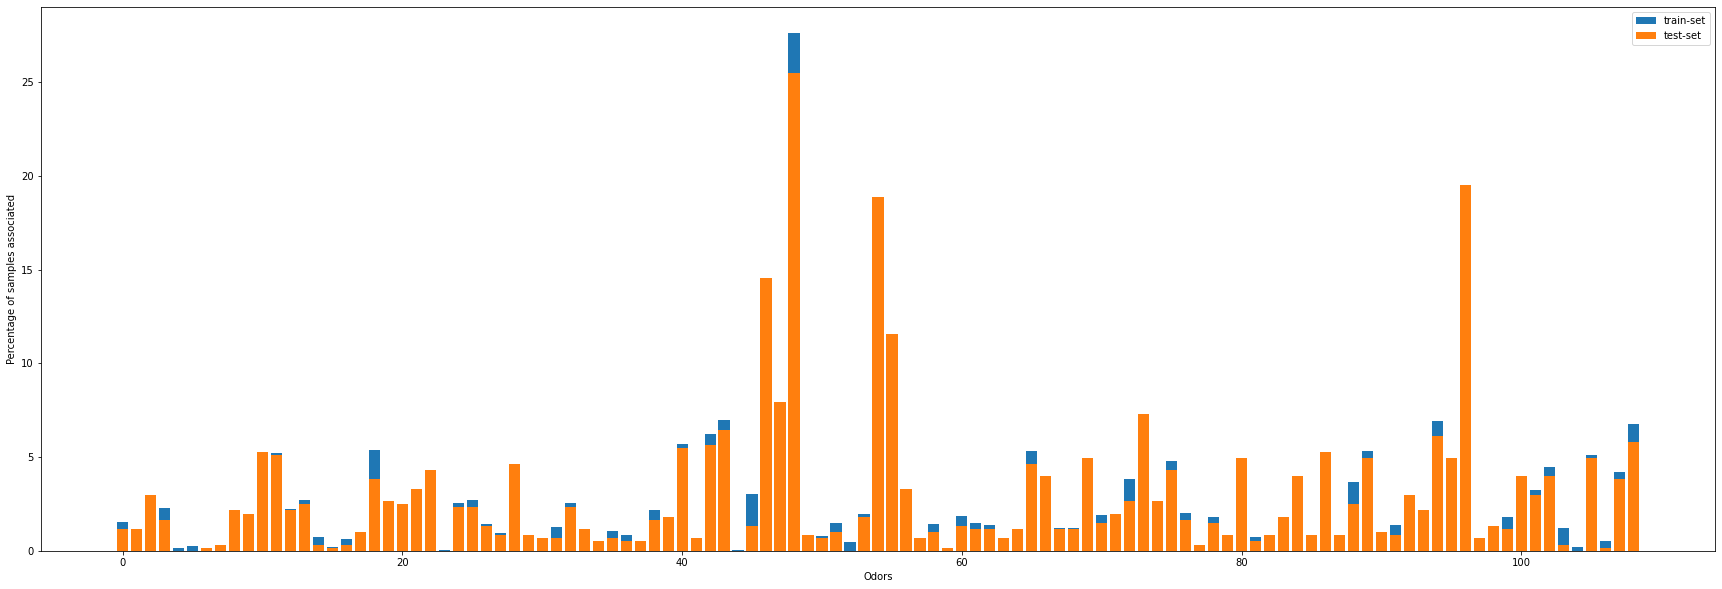

In [33]:


label_distribution(np.array(Y_train),np.array(Y_test))#label distribution while doing a random split


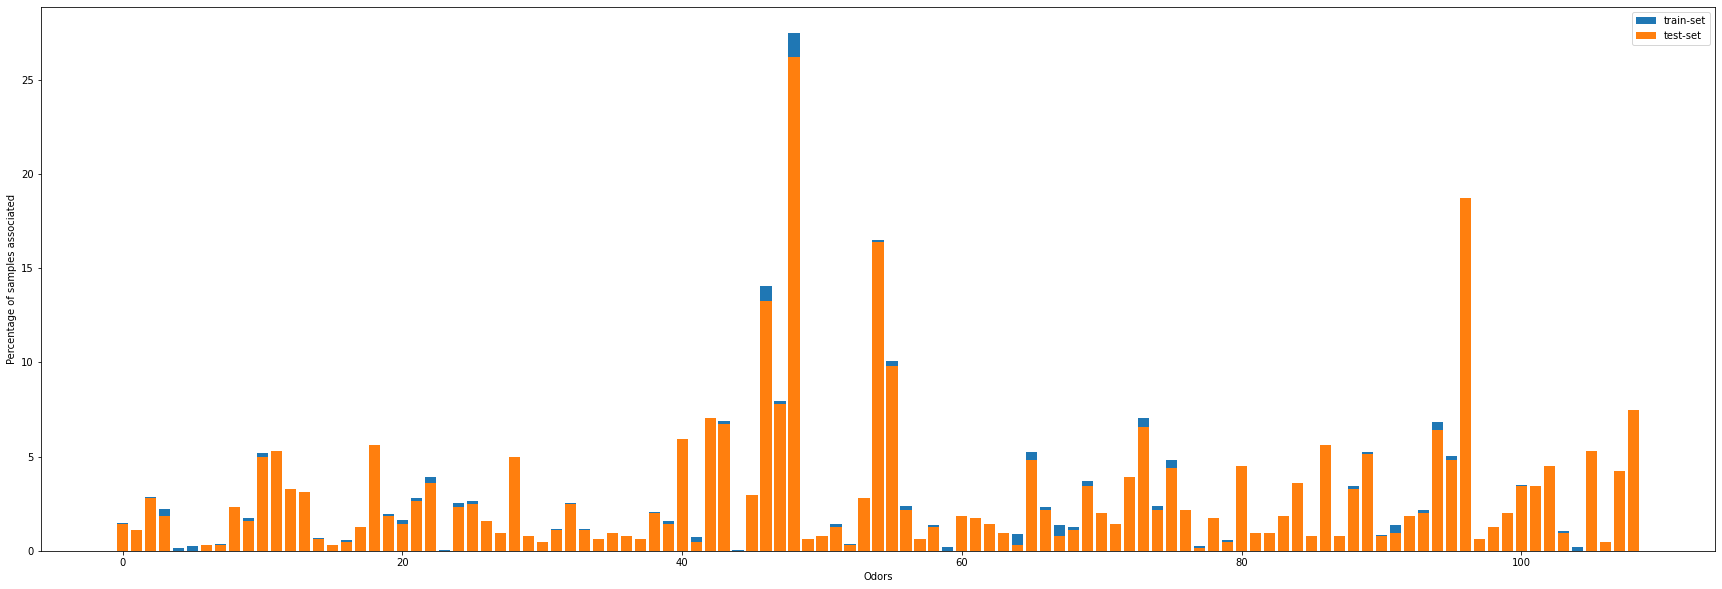

In [34]:

label_distribution(y_train,y_test)# label distribution while doing a stratified split


In [35]:
pip install python-louvain


Defaulting to user installation because normal site-packages is not writeable
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9414 sha256=ceb719da68032127226b258caea940984cef2f8267e5adf499bccfecbccf878b
  Stored in directory: c:\users\91830\appdata\local\pip\cache\wheels\4d\7c\b6\79b198e4ec43f915fbdf967953d48b89a18893b12aa9df0ae2
Successfully built python-louvain
Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install networkx
!pip install python-louvain
!pip install scikit-multilearn




Defaulting to user installation because normal site-packages is not writeable


In [ ]:
!pip install karateclub


In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Assuming you have defined x_train, y_train, and classes before this point

# Step 1: Create the label co-occurrence matrix
label_cooc_matrix = np.dot(y_train.T, y_train)

# Step 2: Perform KMeans clustering on the label co-occurrence matrix
num_clusters = 5  # You can adjust the number of clusters as desired
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(label_cooc_matrix)

# Step 3: Create the networkx graph
G = nx.Graph()
for i, label in enumerate(classes):
    G.add_node(i, label=label)

for i in range(num_clusters):
    cluster_indices = np.where(cluster_labels == i)[0]
    for u in cluster_indices:
        for v in cluster_indices:
            if u != v:
                weight = label_cooc_matrix[u, v]
                G.add_edge(u, v, weight=weight)

# Step 4: Visualize the graph with clusters
names_dict = dict(enumerate(x for x in classes))
pos = nx.spring_layout(G, k=4)

plt.figure(figsize=(15, 9.5))
nx.draw_networkx(
    G,
    pos=pos,
    labels=names_dict,
    with_labels=True,
    width=[10 * G[u][v]['weight'] for u, v in G.edges()],
    node_color=[cluster_labels[i] for i in range(len(classes))],
    cmap=plt.cm.viridis,
    node_size=1000,
    font_size=12,
    font_color='black',
    alpha=0.7,
    ax=plt.gca()  # Use the current Axes instance
)
plt.show()


In [ ]:

from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
graph_builder = LabelCooccurrenceGraphBuilder(weighted=True,
                                              include_self_edges=False)

label_names=[i for i in range(109)]
edge_map = graph_builder.transform(np.array(y_train))
print("{} labels, {} edges".format(len(label_names), len(edge_map)))


In [ ]:

# #import numpy as np
# # import networkx as nx
# # from karateclub import Node2Vec
# # from sklearn.cluster import KMeans

# # # Assuming you already have x_train and y_train defined
# # # Assuming you have a binary label matrix
# # edge_list = []
# # for i in range(y_train.shape[1]):
# #     for j in range(i + 1, y_train.shape[1]):
# #         if np.any(y_train[:, i] & y_train[:, j]):
# #             edge_list.append((i, j))

# # # Create a networkx graph from the edge_list
# # graph = nx.Graph()
# # graph.add_edges_from(edge_list)

# # # Use Node2Vec for embedding
# # model = Node2Vec()
# # model.fit(graph)

# # # Get the embeddings for nodes
# # node_embeddings = model.get_embedding()

# # # Use KMeans for clustering (you can try other clustering algorithms too)
# # num_clusters = 2  # Replace with the desired number of clusters
# # kmeans = KMeans(n_clusters=num_clusters)
# # clusters = kmeans.fit_predict(node_embeddings)

# # # Helper function for visualization
# # def to_membership_vector(clusters):
# #     membership_vector = {}
# #     for i, cluster_id in enumerate(clusters):
# #         if cluster_id not in membership_vector:
# #             membership_vector[cluster_id] = []
# #         membership_vector[cluster_id].append(i)
# #     return membership_vector

# # # Convert the clusters to a membership vector
# # membership_vector = to_membership_vector(clusters)
# # print(membership_vector)


In [ ]:

# # from skmultilearn.cluster import NetworkXLabelGraphClusterer
# # # we define a helper function for visualization purposes
# # def to_membership_vector(partition):
# #     return {
# #         member :  partition_id
# #         for partition_id, members in enumerate(partition)
# #         for member in members
# #     }
# # clusterer = NetworkXLabelGraphClusterer(graph_builder, method='louvain')

In [ ]:

##partition = clusterer.fit_predict(x_train,y_train)


In [ ]:

# # membership_vector = to_membership_vector(partition)
# # print('There are', len(partition),'clusters')

In [ ]:

# # import networkx as nx
# # names_dict = dict(enumerate(x for x in classes))
# # import matplotlib.pyplot as plt
# # get_ipython().run_line_magic('matplotlib', 'inline')
# # plt.figure(1,figsize=(15,9.5))
# # nx.draw(
# #     clusterer.graph_,
# #     pos=nx.spring_layout(clusterer.graph_,k=4),
# #     labels=names_dict,
# #     with_labels = True,
# #     width = [10*x/y_train.shape[0] for x in clusterer.weights_['weight']],
# #     node_color = [membership_vector[i] for i in range(y_train.shape[1])],
# #     cmap=plt.cm.viridis,
# #     node_size=1000,
# #     font_size=12,
# #     font_color='black',
# #     alpha=0.7
# # )
# # plt.show()


# # # # Preprocessing the data

# # # Now we look to preprocess our feature set. As explained above we've used three different featurization strategies.We will now take a look at the feature set generated by each.


In [ ]:


x_morg=morgan_fing(df)
x_morg.head()

In [ ]:


x_path=path_based_fing(df)
x_path.head()

# Since fingerprint based featurization just gives us an array of 0's and 1's there will be no missing values and we don't need to apply standardisation either in the name of pre-processing.Let's now peak at our modred featurization


In [ ]:

x_mord=pd.read_csv("mor_3036.csv")
x_mord.head()

In [ ]:

x_mord=x_mord.astype(float)

In [ ]:

x_mord.shape


# x_mord.dropna(axis=1,inplace=True)
# x_mord.shape

# There seems to be a lot of missing values in mordred featurization,let's check which features have the highest missing values


In [ ]:


l=dict(x_mord.isna().sum(axis=0))#Feature wise
m=dict(x_mord.isna().sum(axis=1))#sample wise

In [ ]:


x=sorted(l.items(),key=lambda x:x[1],reverse=True)
y=sorted(m.items(),key=lambda x:x[1],reverse=True)
print(x)
print(y)


# Since we want to try and retain as many features as possible, we will drop those features which have a lot of values missing(eg-"MINssB" which has only 1 non missing value) and impute the rest using KNN strategy.
#
# We also opt not to drop missing values row wise because each molecule contains important information in the context of the Odor prediction task

# Let's look at the precentage of missing values for each column.


In [ ]:


for key,value in l.items():
  l[key]=(value/(x_mord.shape[0]))*100

In [ ]:

x=sorted(l.items(),key=lambda x:x[1],reverse=True)

In [ ]:

print(x)

In [ ]:


drop_columns=[i[0] for i in x if i[1]>40]#We'll drop columns which have more than 40 percent missing values


In [ ]:

print(drop_columns,)

In [ ]:

x_mord.drop(labels=drop_columns,axis=1,inplace=True)

In [ ]:

list_of_columns=x_mord.columns

In [ ]:

x_mord.info()


# The no of dimenstions for our feature set is very large(1436), so it might be prudent to apply a dimensionality reduction technique like PCA so that it's easier to train our model.

# Now let's build a pre-processing pipline for our mordred featurisation that can apply imputation,standardisation and PCA transformation on our data.


In [ ]:

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA

def pre_process(x_train,x_test):
  imp=KNNImputer(missing_values=np.nan)
  x_train=imp.fit_transform(x_train)
  x_test=imp.transform(x_test)

  '''scale=StandardScaler()
  x_train=scale.fit_transform(x_train)
  x_test=scale.transform(x_test)

  pca=PCA(n_components=0.9999)
  x_train=pca.fit_transform(x_train)
  x_test=pca.transform(x_test)
  print("No of components", pca.n_components_)'''
  return x_train,x_test


# # Training and evaluating our model


In [ ]:

#We choose Random forest as our model.The choice for model is based on similar challanges in cheminformatics
#where the convention is to use Random forests for predicting molecular property.They are also very powerful
#in capturing non-linear relationships and robust to outliers.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
import statistics
from sklearn.metrics import f1_score,precision_score,recall_score,jaccard_score,multilabel_confusion_matrix
#Utility function to get model performance
def eval_train(model,x,y):

  #splitting the data
  x_train,y_train,x_test,y_test=iterative_split(x,y,test_size=0.2)

  x_train,x_test=pre_process(x_train,x_test)

  #Fitting our model
  model.fit(x_train,y_train)

  #Getting predictions on training set
  #y_train_prediction=cross_val_predict(model,x_train,y_train,cv=MultilabelStratifiedKFold(n_splits=3))

  #Building a confusion matrix
  #mcf_matrix=multilabel_confusion_matrix(y_train,y_train_prediction)
  #print(mcf_matrix)
  #Evaluating model performance on training data
  train_score=cross_validate(model,x_train,y_train,scoring=["f1_micro","precision_micro","recall_micro"],cv=MultilabelStratifiedKFold(n_splits=5))
  print(statistics.mean(train_score["test_f1_micro"]))
  print(statistics.mean(train_score["test_precision_micro"]))
  print(statistics.mean(train_score["test_recall_micro"]))

  #Evaluating on test data
  y_pred=model.predict(x_test)
  print("f1_score {}".format(f1_score(y_test,y_pred,average="micro")))
  print("precision_score {}".format(precision_score(y_test,y_pred,average="micro")))
  print("recall_score {}".format(recall_score(y_test,y_pred,average="micro")))


# ## Evaluation Metrics being used

#
# ### Label based
#
# * To measure a multi-class/label classifier we have to average
# out the classes somehow. There are two different methods of doing this called micro-averaging and macro-averaging.
#
# * In micro-averaging method, you sum up the individual true positives, false positives, and false negatives of the system for different label sets and then average them. And the micro-averaged F1-Score will be simply the harmonic mean of micro_precision and micro_recall


In [ ]:


#Image("handson-ml/datasets/Summer_Project_Learning_To_Smell!/Images/confusion_matrix.png")


In [ ]:

#Image("handson-ml/datasets/Summer_Project_Learning_To_Smell!/Images/micro_avg.png")

# * With macro-averaging we just average the precision and recall scores over all label sets


In [ ]:

#Image("handson-ml/datasets/Summer_Project_Learning_To_Smell!/Images/macro_avg.png")


# For the purpose of this task we shall use micro-averaged metrics since they give a more realistic idea of performance for imbalanced datasets.

# ## Approches to solving multilabel classification problems

# ### Using random forest


In [ ]:

from sklearn.ensemble import RandomForestClassifier
def get_rf():
  rf= RandomForestClassifier(random_state=42,class_weight="balanced",n_jobs=-1)
  return rf


# ### Binary Relevance

# The basic idea of this algorithm is to decompose the multi-label learning problem into q independent binary classification problems, where each binary classification
# problem corresponds to a possible label in the label space.
#
# This technique fails to capture any label correlations under first order strategy.


In [ ]:

from skmultilearn.problem_transform import BinaryRelevance
from sklearn.ensemble import RandomForestClassifier
def get_bin_rel():
  classifier = BinaryRelevance(
      classifier = RandomForestClassifier(random_state=42,class_weight="balanced",n_jobs=-1))
  return classifier


# ### Classifier Chains

# This algorithm transforms the multi-label learning
# problem into a chain of binary classification problems, where subsequent binary classifiers in
# the chain is built upon the predictions of the preceding ones


In [ ]:
from skmultilearn.problem_transform import ClassifierChain
def get_cls_chain():
  classifier = ClassifierChain(
      classifier = RandomForestClassifier(random_state=42,n_jobs=-1,class_weight="balanced"),
      require_dense = [False, True],
      order=[i for i in range(len(vocab))]
  )
  return classifier

# import matplotlib.pyplot as plt
# from sklearn.tree import plot_tree
# rnd_clf= RandomForestClassifier(random_state=42,class_weight="balanced",n_jobs=-1)
# rnd_clf.fit(x_mord,Y)
# fig = plt.figure(figsize=(50, 30))
# plot_tree(rnd_clf.estimators_[0],
#           feature_names=x_mord.columns,
#           class_names=enc.classes_,
#           filled=True, impurity=True,
#           rounded=True,max_depth=1)

# ## Using Mordred featurization

In [ ]:
import pickle

# Specify the path to your .pkl file
model_file_path = 'binary_relevance_model.pkl'

# Load the model from the .pkl file
with open(model_file_path, 'rb') as file:
    model3 = pickle.load(file)

# Now, you can use the loaded_model for inference or other tasks
# For example:
# result = loaded_model.predict(input_data)


In [ ]:

model=get_rf()
eval_train(model,x_mord,Y)

0.23655224308117825
0.39084761940341434
0.16972455591278032
f1_score 0.2815564694716862
precision_score 0.39520426287744226
recall_score 0.21867321867321868


In [ ]:

pip install -U yellowbrick

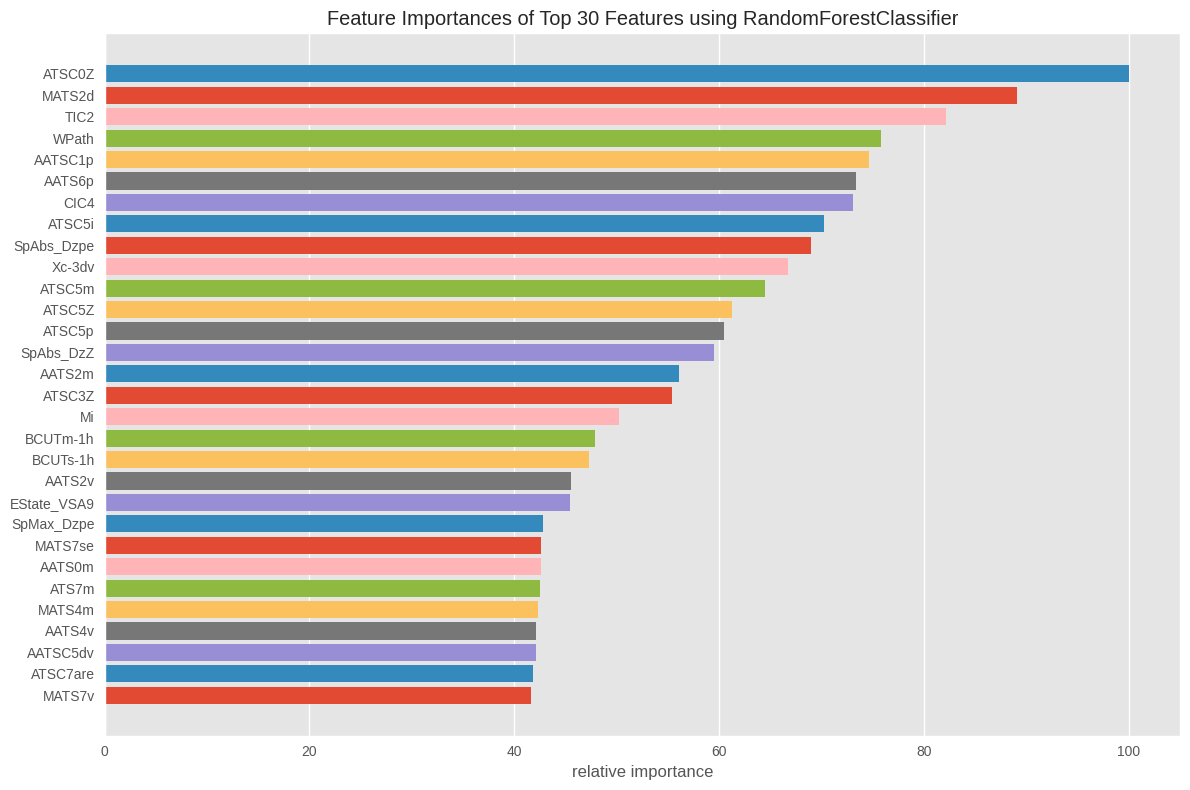

<Axes: title={'center': 'Feature Importances of Top 30 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [ ]:

import yellowbrick
from yellowbrick.model_selection import FeatureImportances
plt.rcParams['figure.figsize'] = (12,8)
plt.style.use("ggplot")

viz = FeatureImportances(model,topn=30,labels=list_of_columns)

viz.fit(x_train, y_train)
viz.show()

In [73]:

model=get_bin_rel()
eval_train(model,x_mord,Y)


0.2997804805032376
0.40099963089654983
0.23946070430972202
f1_score 0.3322812051649928
precision_score 0.3993103448275862
recall_score 0.28452088452088453


In [74]:


model=get_cls_chain()
eval_train(model,x_mord,Y)


# ## Using morgan featurization



0.28964169251324035
0.4152301284825281
0.222449425741697
f1_score 0.3266286400480336
precision_score 0.41975308641975306
recall_score 0.2673218673218673


In [75]:

model=get_rf()
eval_train(model,x_morg,Y)

0.2534589093565627
0.36609137530439223
0.19406485131831802
f1_score 0.29755515802027427
precision_score 0.378316906747536
recall_score 0.2452088452088452


In [76]:

model=get_bin_rel()
eval_train(model,x_morg.astype(float),Y)

0.29488021657179486
0.3567172619393968
0.2517344271925164
f1_score 0.32794830371567046
precision_score 0.3627159023228112
recall_score 0.2992628992628993


In [77]:

model=get_cls_chain()
eval_train(model,x_morg.astype(float),Y)

# ## Using path based featurization

0.27998556513374195
0.37914883073822975
0.22240687706775616
f1_score 0.3192788601337598
precision_score 0.391025641025641
recall_score 0.2697788697788698


In [78]:


model=get_rf()
eval_train(model,x_path,Y)

0.28739324218117684
0.3662407242986533
0.23666513672522457
f1_score 0.318824507901303
precision_score 0.3657760814249364
recall_score 0.28255528255528256


In [79]:

model=get_bin_rel()
eval_train(model,x_path,Y)

0.3122602703954145
0.3500681771640367
0.2820400873790795
f1_score 0.342769701606733
precision_score 0.3563096500530223
recall_score 0.3302211302211302


In [80]:

model=get_cls_chain()
eval_train(model,x_path,Y)


# # Label Wise model performance

0.30136606309104236
0.37575939982344714
0.25178492384710033
f1_score 0.3437759911283615
precision_score 0.3944020356234097
recall_score 0.3046683046683047


In [81]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score,precision_score,recall_score,jaccard_score,multilabel_confusion_matrix
#Utility function to get model performance
def label_eval(model,x,y):

  #splitting the data
  x_train,y_train,x_test,y_test=iterative_split(x,y,test_size=0.2)

  x_train,x_test=pre_process(x_train,x_test)

  #Fitting our model
  model.fit(x_train,y_train)

  #Evaluating on test data
  y_pred=model.predict(x_test)
  print("f1_score {}".format(f1_score(y_test,y_pred,average="micro")))
  print("precision_score {}".format(precision_score(y_test,y_pred,average="micro")))
  print("recall_score {}".format(recall_score(y_test,y_pred,average="micro")))

  return multilabel_confusion_matrix(y_test,y_pred)

In [82]:

model=get_bin_rel()

In [83]:


cfmatrix=label_eval(model,x_path,Y)

f1_score 0.342769701606733
precision_score 0.3563096500530223
recall_score 0.3302211302211302


In [84]:


cfmatrix.shape

(109, 2, 2)

In [85]:
cfmatrix

array([[[627,   5],
        [  3,   6]],

       [[628,   6],
        [  5,   2]],

       [[612,  11],
        [ 13,   5]],

       [[621,   8],
        [  7,   5]],

       [[641,   0],
        [  0,   0]],

       [[640,   1],
        [  0,   0]],

       [[639,   0],
        [  2,   0]],

       [[639,   0],
        [  1,   1]],

       [[612,  14],
        [  6,   9]],

       [[624,   7],
        [  7,   3]],

       [[587,  22],
        [ 23,   9]],

       [[599,   8],
        [ 20,  14]],

       [[613,   7],
        [ 12,   9]],

       [[607,  14],
        [ 17,   3]],

       [[636,   1],
        [  4,   0]],

       [[637,   2],
        [  2,   0]],

       [[634,   4],
        [  3,   0]],

       [[631,   2],
        [  6,   2]],

       [[594,  11],
        [ 32,   4]],

       [[627,   2],
        [  7,   5]],

       [[630,   2],
        [  8,   1]],

       [[613,  11],
        [ 11,   6]],

       [[609,   9],
        [ 19,   4]],

       [[641,   0],
        [  0, 

In [86]:

df.shape

(3018, 2)

In [87]:

label_per=pd.DataFrame(index=classes,columns=["Precision_score","Recall_score","F1_score","Percentage_of_samples"])


In [88]:


label_per

,Precision_score,Recall_score,F1_score,Percentage_of_samples
alcoholic,NaN,NaN,NaN,NaN
aldehydic,NaN,NaN,NaN,NaN
alliaceous,NaN,NaN,NaN,NaN
almond,NaN,NaN,NaN,NaN
ambergris,NaN,NaN,NaN,NaN
...,...,...,...,...
watery,NaN,NaN,NaN,NaN
waxy,NaN,NaN,NaN,NaN
whiteflower,NaN,NaN,NaN,NaN
wine,NaN,NaN,NaN,NaN


In [89]:

label_per["Percentage_of_samples"]=[((x[1]/df.shape[0])*100) for x in sorted(odor_count.items())]


In [90]:


f1=[]
pre=[]
rec=[]
for lab in cfmatrix:
  p=r=f=0
  if(lab[1][1]!=0):
    p=lab[1][1]/(lab[1][1]+lab[0][1])
    r=lab[1][1]/(lab[1][1]+lab[1][0])
    f=(p*r*2)/(p+r)
  f1.append(f)
  pre.append(p)
  rec.append(r)

In [91]:

label_per["Precision_score"]=pre
label_per["Recall_score"]=rec
label_per["F1_score"]=f1

In [92]:

label_per

,Precision_score,Recall_score,F1_score,Percentage_of_samples
alcoholic,0.545455,0.666667,0.600000,1.457919
aldehydic,0.250000,0.285714,0.266667,0.994036
alliaceous,0.312500,0.277778,0.294118,2.849569
almond,0.384615,0.416667,0.400000,2.153744
ambergris,0.000000,0.000000,0.000000,0.099404
...,...,...,...,...
watery,0.000000,0.000000,0.000000,0.165673
waxy,0.309091,0.500000,0.382022,5.069583
whiteflower,0.000000,0.000000,0.000000,0.463883
wine,0.523810,0.407407,0.458333,4.108681


In [93]:


label_per["Percentage_of_samples"].max()

27.20344599072233

In [94]:

lb=label_per.drop(labels=label_per[label_per["F1_score"]==0].index,axis=0).sort_values(by="F1_score")


In [95]:

lb[:15]

,Precision_score,Recall_score,F1_score,Percentage_of_samples
tropicalfruit,0.153846,0.090909,0.114286,3.479125
clean,0.090909,0.200000,0.125000,0.728960
dairy,0.125000,0.153846,0.137931,2.054341
grass,0.222222,0.111111,0.148148,1.988072
resinous,0.266667,0.111111,0.156863,4.340623
burnt,0.266667,0.111111,0.156863,5.069583
spicy,0.227273,0.121951,0.158730,6.958250
berry,0.176471,0.150000,0.162162,2.650762
cacao,0.333333,0.111111,0.166667,1.590457
melon,0.117647,0.400000,0.181818,1.225977


In [96]:

lb[:15]["Percentage_of_samples"].mean()

3.2228849127457475

In [97]:

lb[-15:].sort_values(by="F1_score",ascending=False)


,Precision_score,Recall_score,F1_score,Percentage_of_samples
ammoniac,1.000000,0.500000,0.666667,0.331345
mint,0.608696,0.636364,0.622222,3.644798
honey,0.600000,0.642857,0.620690,2.352551
alcoholic,0.545455,0.666667,0.600000,1.457919
lily,0.600000,0.500000,0.545455,0.596421
coffee,0.571429,0.500000,0.533333,2.518224
butter,0.714286,0.416667,0.526316,1.954937
fruity,0.514970,0.511905,0.513433,27.203446
vanilla,0.523810,0.500000,0.511628,3.180915
cucumber,0.500000,0.500000,0.500000,0.530152


In [98]:

lb[-15:].sort_values(by="F1_score",ascending=False)["Percentage_of_samples"].mean()


3.635962005743317

In [99]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.multioutput import ClassifierChain
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import jaccard_score
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score,precision_score,recall_score,jaccard_score,multilabel_confusion_matrix

x_train,y_train,x_test,y_test=iterative_split(x_mord,Y,test_size=0.2)

x_train,x_test=pre_process(x_train,x_test)

base_lr = get_rf()
# Fit an ensemble of logistic regression classifier chains and take the
# take the average prediction of all the chains.
chains = [ClassifierChain(base_lr, order='random', random_state=i)
          for i in range(10)]
for chain in chains:
    chain.fit(x_train, y_train)

Y_pred_chains = np.array([chain.predict(x_test) for chain in
                          chains])

y_pred= Y_pred_chains.mean(axis=0)
y_pred = y_pred.round()

print("f1_score {}".format(f1_score(y_test,y_pred,average="micro")))
print("precision_score {}".format(precision_score(y_test,y_pred,average="micro")))
print("recall_score {}".format(recall_score(y_test,y_pred,average="micro")))
print("jaccard_score {}".format(jaccard_score(y_test,y_pred,average="micro")))


f1_score 0.3257781807192505
precision_score 0.4230769230769231
recall_score 0.2648648648648649
jaccard_score 0.19458483754512634


In [100]:
y_pred = y_pred.round()

print("f1_score {}".format(f1_score(y_test,y_pred,average="micro")))
print("precision_score {}".format(precision_score(y_test,y_pred,average="micro")))
print("recall_score {}".format(recall_score(y_test,y_pred,average="micro")))
print("jaccard_score {}".format(jaccard_score(y_test,y_pred,average="micro")))


f1_score 0.3257781807192505
precision_score 0.4230769230769231
recall_score 0.2648648648648649
jaccard_score 0.19458483754512634


In [101]:

Y_pred_chains.shape

(10, 641, 109)

In [102]:

y_pred_t=y_pred

In [103]:

y_pred_temp=y_pred_t

In [104]:

for i in range(y_pred_temp.shape[0]):
  for j in range(y_pred_temp.shape[1]):
    if (y_pred_temp[i][j]>0.5):
      y_pred_temp[i][j]=1
    else:
      y_pred_temp[i][j]=0

In [105]:

y_pred_temp[3]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [106]:

print("f1_score {}".format(f1_score(y_test,y_pred_temp,average="micro")))
print("precision_score {}".format(precision_score(y_test,y_pred_temp,average="micro")))
print("recall_score {}".format(recall_score(y_test,y_pred_temp,average="micro")))
print("jaccard_score {}".format(jaccard_score(y_test,y_pred_temp,average="micro")))

f1_score 0.3257781807192505
precision_score 0.4230769230769231
recall_score 0.2648648648648649
jaccard_score 0.19458483754512634
